In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines  # will first need to install labellines package

seedno = 12345
rng = np.random.default_rng(seed=seedno)

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
# font size for labels in plots
fs = 15
dpi = 300
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

## Model parameters

In [3]:
sigma = 1
S0 = 100.
T = 1.
lambda_a = 10.
lambda_b = 10.  
qmax = 10
qmin = -qmax
sigma_Z = 1.
kappa = 2.
# Model for misses
eta = 0.01 # TICK SIZE
alpha_a = 0.1
alpha_b = 0.1
beta = 0.1

# Penalties
phi = 0.1
a = 1e-3

# changes font in plots
fontnm = "Times New Roman" 
tnrfont = {'fontname':fontnm} 

In [4]:
all_inventories = np.arange(qmax, qmin-1, step = -1)

## Implementation

In [5]:
def _calculate_omega_t(t):
    # A represents integrated A in this code
    A_matrix = np.zeros((2*qmax+1,2*qmax+1))
    vector = np.zeros((2*qmax+1,1))
    for i in range(2*qmax+1):
        inventory = qmax - i
        A_matrix[i, i] = - phi * kappa * inventory**2 + beta * (lambda_b - lambda_a) * inventory
        vector[i, 0] = np.exp(- a * kappa * inventory**2)
        if i + 1 < (2*qmax+1):
            A_matrix[i, i + 1] = lambda_b * np.exp(-1.+kappa*alpha_b - kappa*beta*inventory) 
        if i > 0:
            A_matrix[i, i - 1] = lambda_a * np.exp(-1.+kappa*alpha_a + kappa*beta*inventory) 
    return np.matmul(expm(A_matrix*(T-t) ), vector)

In [6]:
def _calculate_gt(t):
    omega_function = _calculate_omega_t(t)
    return (1 / kappa) * np.log(omega_function)

def _calculate_ht(t, d_plus_z):
    return _calculate_gt(t) + beta* all_inventories.reshape(-1,1) * d_plus_z

In [7]:
def _calculate_deltas(t, q, d_plus_z, take_maximum = True):    
    delta_tilde_a = alpha_a + beta * (d_plus_z)
    delta_tilde_b = alpha_a - beta * (d_plus_z)
    
    g_qs = _calculate_gt(t)
    
    indices = np.clip(qmax - q, 0, 2 * qmax)
    indices = indices.astype(int)
    indices_minus_one = np.clip(indices + 1, 0, 2 * qmax)  # moving up an index corresponds to lower inventory
    indices_plus_one = np.clip(indices - 1, 0, 2 * qmax) # moving down an index corresponds to higher inventory
    
    #d_plus_z_term = beta * q * d_plus_z
    #d_plus_z_term_q_minus_one = beta * (all_inventories[indices_minus_one]) * d_plus_z
    d_plus_z_term_q_minus_one = beta * np.clip(q-1, a_min=qmin,a_max=qmax) * d_plus_z
    d_plus_z_term_q_plus_one = beta * np.clip(q+1, a_min=qmin,a_max=qmax) * d_plus_z
    d_plus_z_minus_one_term = beta * q * (d_plus_z - 1)
    d_plus_z_plus_one_term = beta * q * (d_plus_z + 1)
    
    
    h_q_minus_one = np.squeeze(g_qs[indices_minus_one]) + d_plus_z_term_q_minus_one
    h_d_minus_one = np.squeeze(g_qs[indices]) + d_plus_z_minus_one_term
    
    h_q_plus_one = np.squeeze(g_qs[indices_plus_one]) + d_plus_z_term_q_plus_one
    h_d_plus_one = np.squeeze(g_qs[indices]) +  d_plus_z_plus_one_term
    
    delta_hat_a = 1/kappa - h_q_minus_one + h_d_minus_one
    delta_hat_b = 1/kappa - h_q_plus_one + h_d_plus_one
    
    if take_maximum:
        delta_a = np.maximum(delta_hat_a, delta_tilde_a)
        delta_b = np.maximum(delta_hat_b, delta_tilde_b)
        return delta_a, delta_b
    else:
        return delta_hat_a, delta_hat_b

# Numerics

In [8]:
t = 0.5
d_plus_z = 0

q_vector = np.arange(qmax-1,qmin,step=-1)
d_plus_z_vector = np.arange(10-1,-10,step=-1)

deltas_a = np.zeros((len(q_vector), len(d_plus_z_vector)))
deltas_b = np.zeros((len(q_vector), len(d_plus_z_vector)))

for j,d in enumerate(d_plus_z_vector):
    for i,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, d, take_maximum=False)
        deltas_a[i, j] = delta_a
        deltas_b[i, j] = delta_b

In [9]:
print(deltas_a[0,:])

[-0.68512487 -0.78512487 -0.88512487 -0.98512487 -1.08512487 -1.18512487
 -1.28512487 -1.38512487 -1.48512487 -1.58512487 -1.68512487 -1.78512487
 -1.88512487 -1.98512487 -2.08512487 -2.18512487 -2.28512487 -2.38512487
 -2.48512487]


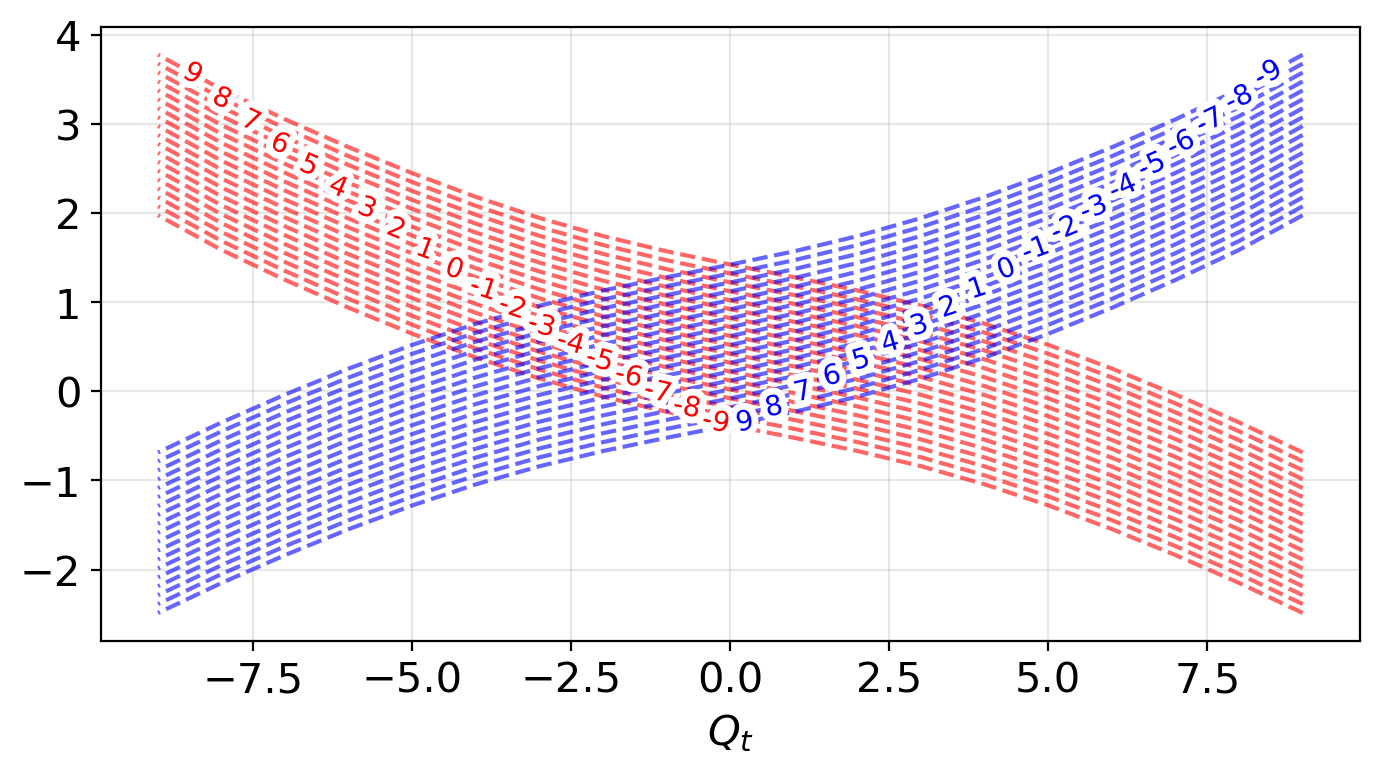

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (7,4), sharey=False, sharex=True)
labels = []
for lable in d_plus_z_vector:
    labels.append(str(lable))
ax.plot(q_vector, deltas_a, 'r--', label=labels, alpha = 0.6)
ax.plot(q_vector, deltas_b, 'b--', label=labels, alpha = 0.6)
plt.grid(alpha=0.3)
plt.xlabel(r'$Q_t$', fontsize=fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
labelLines(ax.get_lines(), zorder=2.5)
plt.tight_layout()
#plt.savefig('figures/approxoptdepths.pdf', format="pdf", dpi=dpi)
plt.show()

In [11]:
t = 0.5
q = 0
dmax = 5
dmin = - dmax

d_plus_z_vector = np.arange(dmax-1,dmin,step=-1)

deltas_a = np.zeros((d_plus_z_vector.shape))
deltas_b = np.zeros((d_plus_z_vector.shape))

for i,d_z in enumerate(d_plus_z_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_z)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b

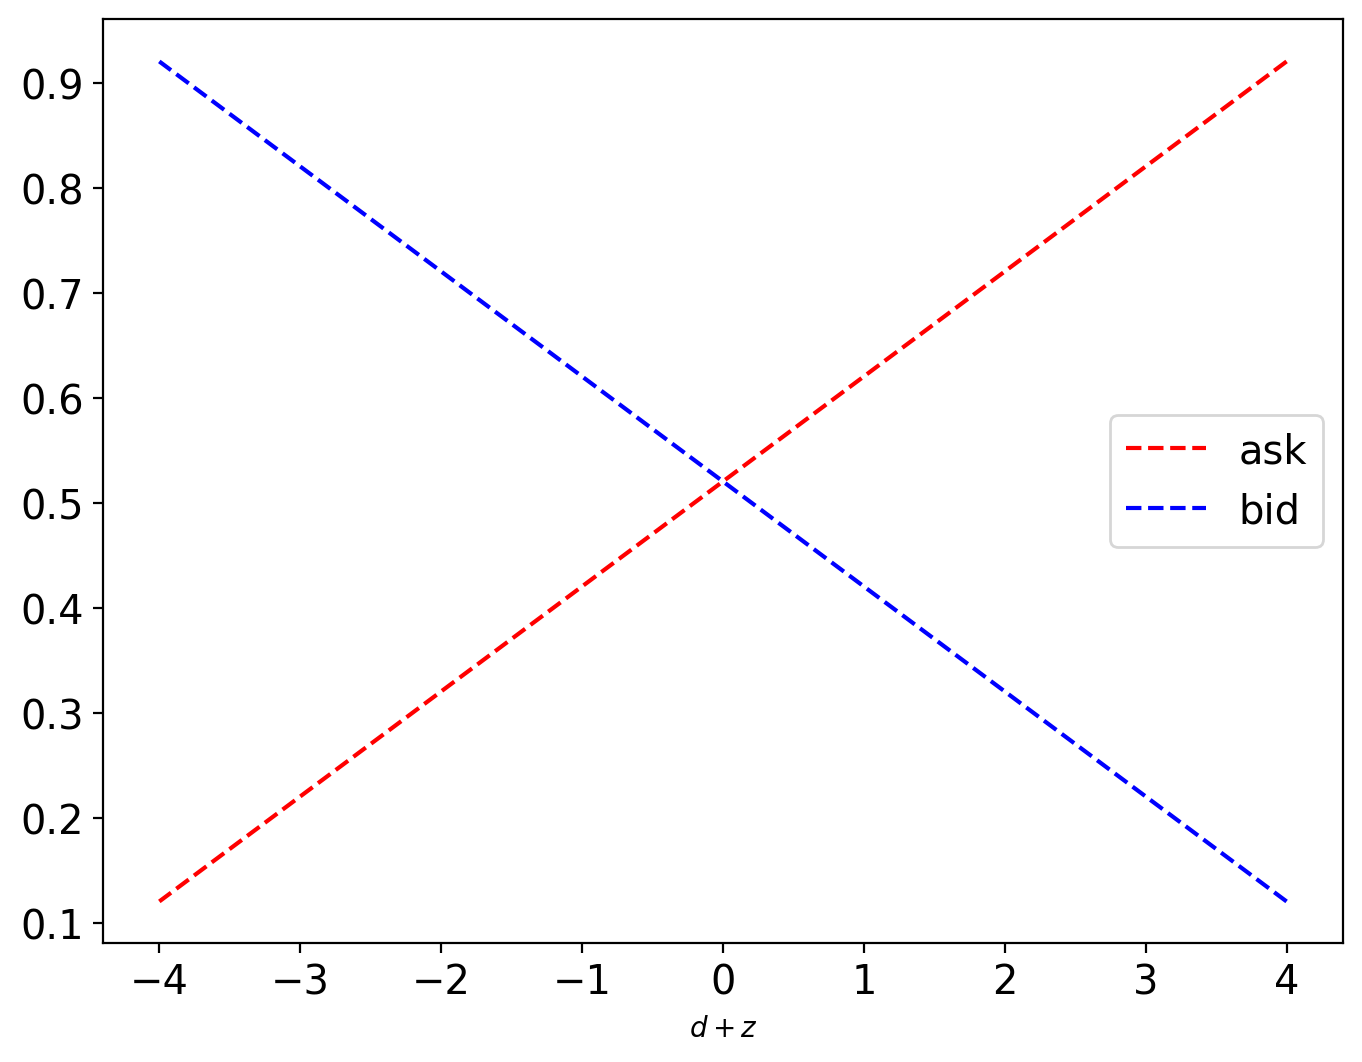

In [12]:
plt.plot(d_plus_z_vector, deltas_a, 'r--')
plt.plot(d_plus_z_vector, deltas_b, 'b--')
plt.xlabel(r'$d+z$')
plt.legend(['ask','bid'])
plt.show()

In [13]:
t_vector = np.linspace(0,T,num=100)
q_vector = np.arange(qmax-1,qmin,step=-1)

d_plus_z = 0


deltas_a = np.zeros((t_vector.shape[0],q_vector.shape[0]))
deltas_b = np.zeros((t_vector.shape[0],q_vector.shape[0]))

for it,t in enumerate(t_vector):
    for iq,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
        deltas_a[it,iq] = delta_a
        deltas_b[it,iq] = delta_b

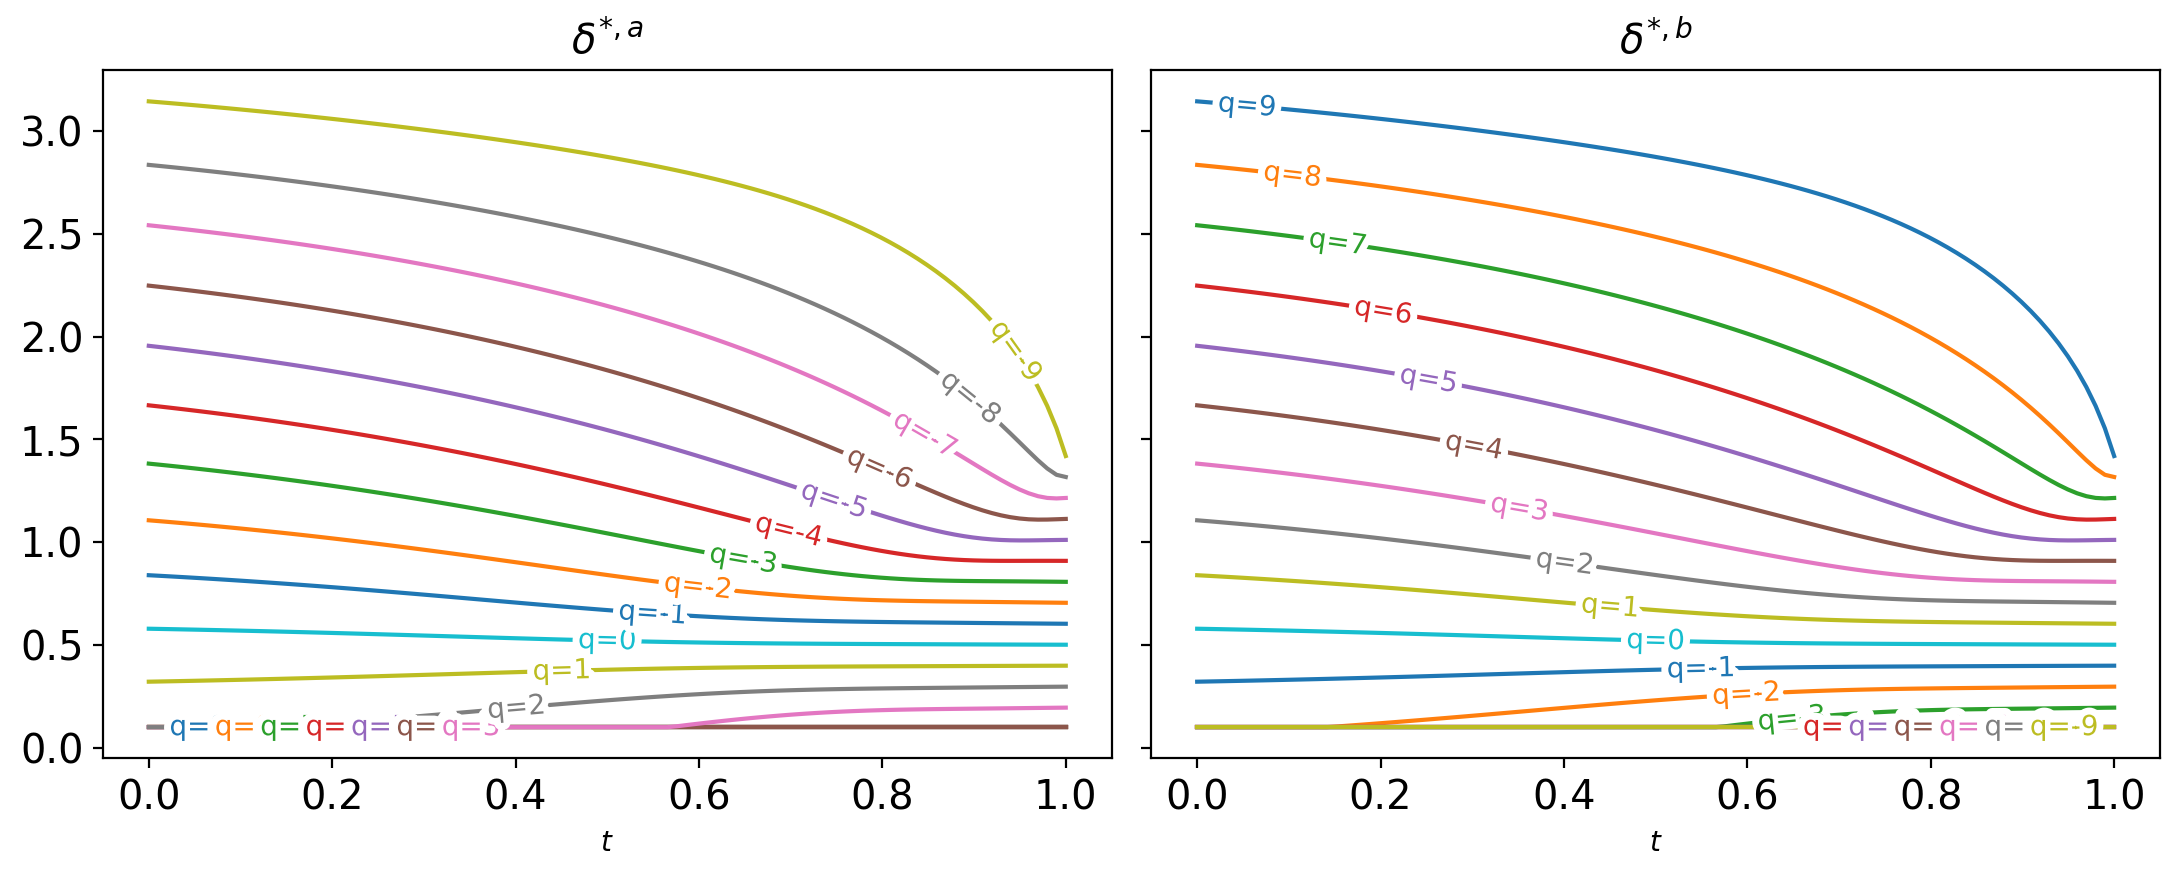

In [14]:
fig, ax = plt.subplots(1,2, figsize = (11,4.5), sharey=True)
for iq,q in enumerate(q_vector):
    ax[0].plot(t_vector, deltas_a[:,iq], label="q="+str(q))
    ax[1].plot(t_vector, deltas_b[:,iq], label="q="+str(q))
#ax[0].legend([f'q = {q}' for q in q_vector])
ax[0].set_xlabel(r'$t$')
ax[1].set_xlabel(r'$t$')
ax[0].set_title(r'$\delta^{*,a}$')
ax[1].set_title(r'$\delta^{*,b}$')
labelLines(ax[0].get_lines(), zorder=2.5)
labelLines(ax[1].get_lines(), zorder=2.5)
plt.tight_layout()
#plt.savefig('figures/sample_path_main_processes.pdf', format="pdf", dpi=dpi)
plt.show()

# Experiments

In [15]:
def brownian(Nt=1000, S0=0, sigma=0.01):
    timesteps = np.linspace(0, T, Nt)
    path = np.zeros(Nt)
    path[0] = S0
    Z = rng.normal(0,1, Nt)
    for n in range(1, Nt):
        path[n] = path[n-1] + sigma * np.sqrt(T/Nt) * Z[n]
    return path

def get_arrival(sims, dt, lambda_a, lambda_b):
    unif_a = rng.uniform(size=(sims,))
    unif_b = rng.uniform(size=(sims,))
    return unif_a < 1. - np.exp(-lambda_a * dt), unif_b < 1. - np.exp(-lambda_b * dt)

In [16]:
Nt = 1000
sims = 1_000
dt = T/Nt

X = np.zeros((sims,Nt+1))
Q = np.zeros((sims,Nt+1))
D = np.zeros((sims,Nt+1))
S = np.zeros((sims,Nt+1))
Z = np.zeros((sims,Nt+1))
pnl = np.zeros(sims)
intQ = np.zeros(sims)
objective = np.zeros(sims)

deltas_a = np.zeros((sims, Nt+1))
deltas_b = np.zeros((sims, Nt+1))
tildes_a = np.zeros((sims, Nt+1))
tildes_b = np.zeros((sims, Nt+1))

arrivaltimes_a = np.zeros((sims, Nt+1))
arrivaltimes_b = np.zeros((sims, Nt+1))

S[:,0] = S0

time = np.linspace(0, T, Nt+1)

In [17]:
it = 0
delta_a, delta_b = _calculate_deltas(t, Q[:,it], D[:,it]+Z[:,it])
delta_a.shape

(1000,)

In [18]:
for it,t in enumerate(time[:-1]):   
    delta_a, delta_b = _calculate_deltas(t, Q[:,it], D[:,it]+Z[:,it])
    
    deltas_a[:, it] = delta_a[:]
    deltas_b[:, it] = delta_b[:]
    
    aux_normal = rng.normal(0, 1)
    Z[:,it+1] = Z[:,it] + sigma_Z *  np.sqrt(T/Nt) * aux_normal
    aux_normal = rng.normal(0, 1)
    S[:,it+1] = S[:,it] + sigma *  np.sqrt(T/Nt) * aux_normal
    
    arrival_a, arrival_b = get_arrival(sims, dt, lambda_a, lambda_b)
    arrivaltimes_a[:,it] = arrival_a*t
    arrivaltimes_b[:,it] = arrival_b*t
    
    fill_a = rng.uniform(size=(sims,))
    fill_b = rng.uniform(size=(sims,))
    
    delta_tilde_a = alpha_a + beta * (D[:,it] + Z[:,it])
    delta_tilde_b = alpha_b - beta * (D[:,it] + Z[:,it])
    tildes_a[:,it] = delta_tilde_a[:]
    tildes_b[:,it] = delta_tilde_b[:]
    
    prob_a = np.minimum(np.exp(-kappa*(delta_a - delta_tilde_a)),1)
    prob_b = np.minimum(np.exp(-kappa*(delta_b - delta_tilde_b)),1)
    
    filled_trade_a = (fill_a < prob_a) * (Q[:,it]!=qmin)
    filled_trade_b = (fill_b < prob_b) * (Q[:,it]!=qmax)
    
    
    Q[:,it+1] = Q[:,it] - filled_trade_a*arrival_a + filled_trade_b*arrival_b
    D[:,it+1] = D[:,it] - (1-filled_trade_a)*arrival_a + (1-filled_trade_b)*arrival_b
    
    X[:,it+1] = X[:,it] + filled_trade_a*arrival_a*(S[:,it] + delta_a) - filled_trade_b*arrival_b*(S[:,it] - delta_a)

pnl[:] = X[:,-1] + Q[:,-1]*S[:,-1]
for s in range(1, sims):
    intQ[s] = np.sum(Q[s,:]**2)/Nt
objective[:] = pnl[:] - a*Q[:,-1]**2 - phi*intQ[:] - beta * (D[:,-1]+Z[:,-1]) * Q[:,-1]
arrivaltimes_a = arrivaltimes_a[arrivaltimes_a!=0]

Terminal Q mean = -0.038              Terminal Q sd = 1.4888
Terminal D mean = 0.346              Terminal D sd = 3.7438
Terminal X mean = 8.3995            Terminal X sd = 148.294
Terminal PnL mean = 4.6376           Terminal PnL sd = 2.815
Terminal objective mean = 4.3579     Terminal objective sd = 2.8494
$Q_{T}$ &-0.038 & 1.4888 \\ 
$D_{T}$ &0.346 & 3.7438 \\ 
$\mathcal{J}$ &4.3579 & 2.8494 \\ 


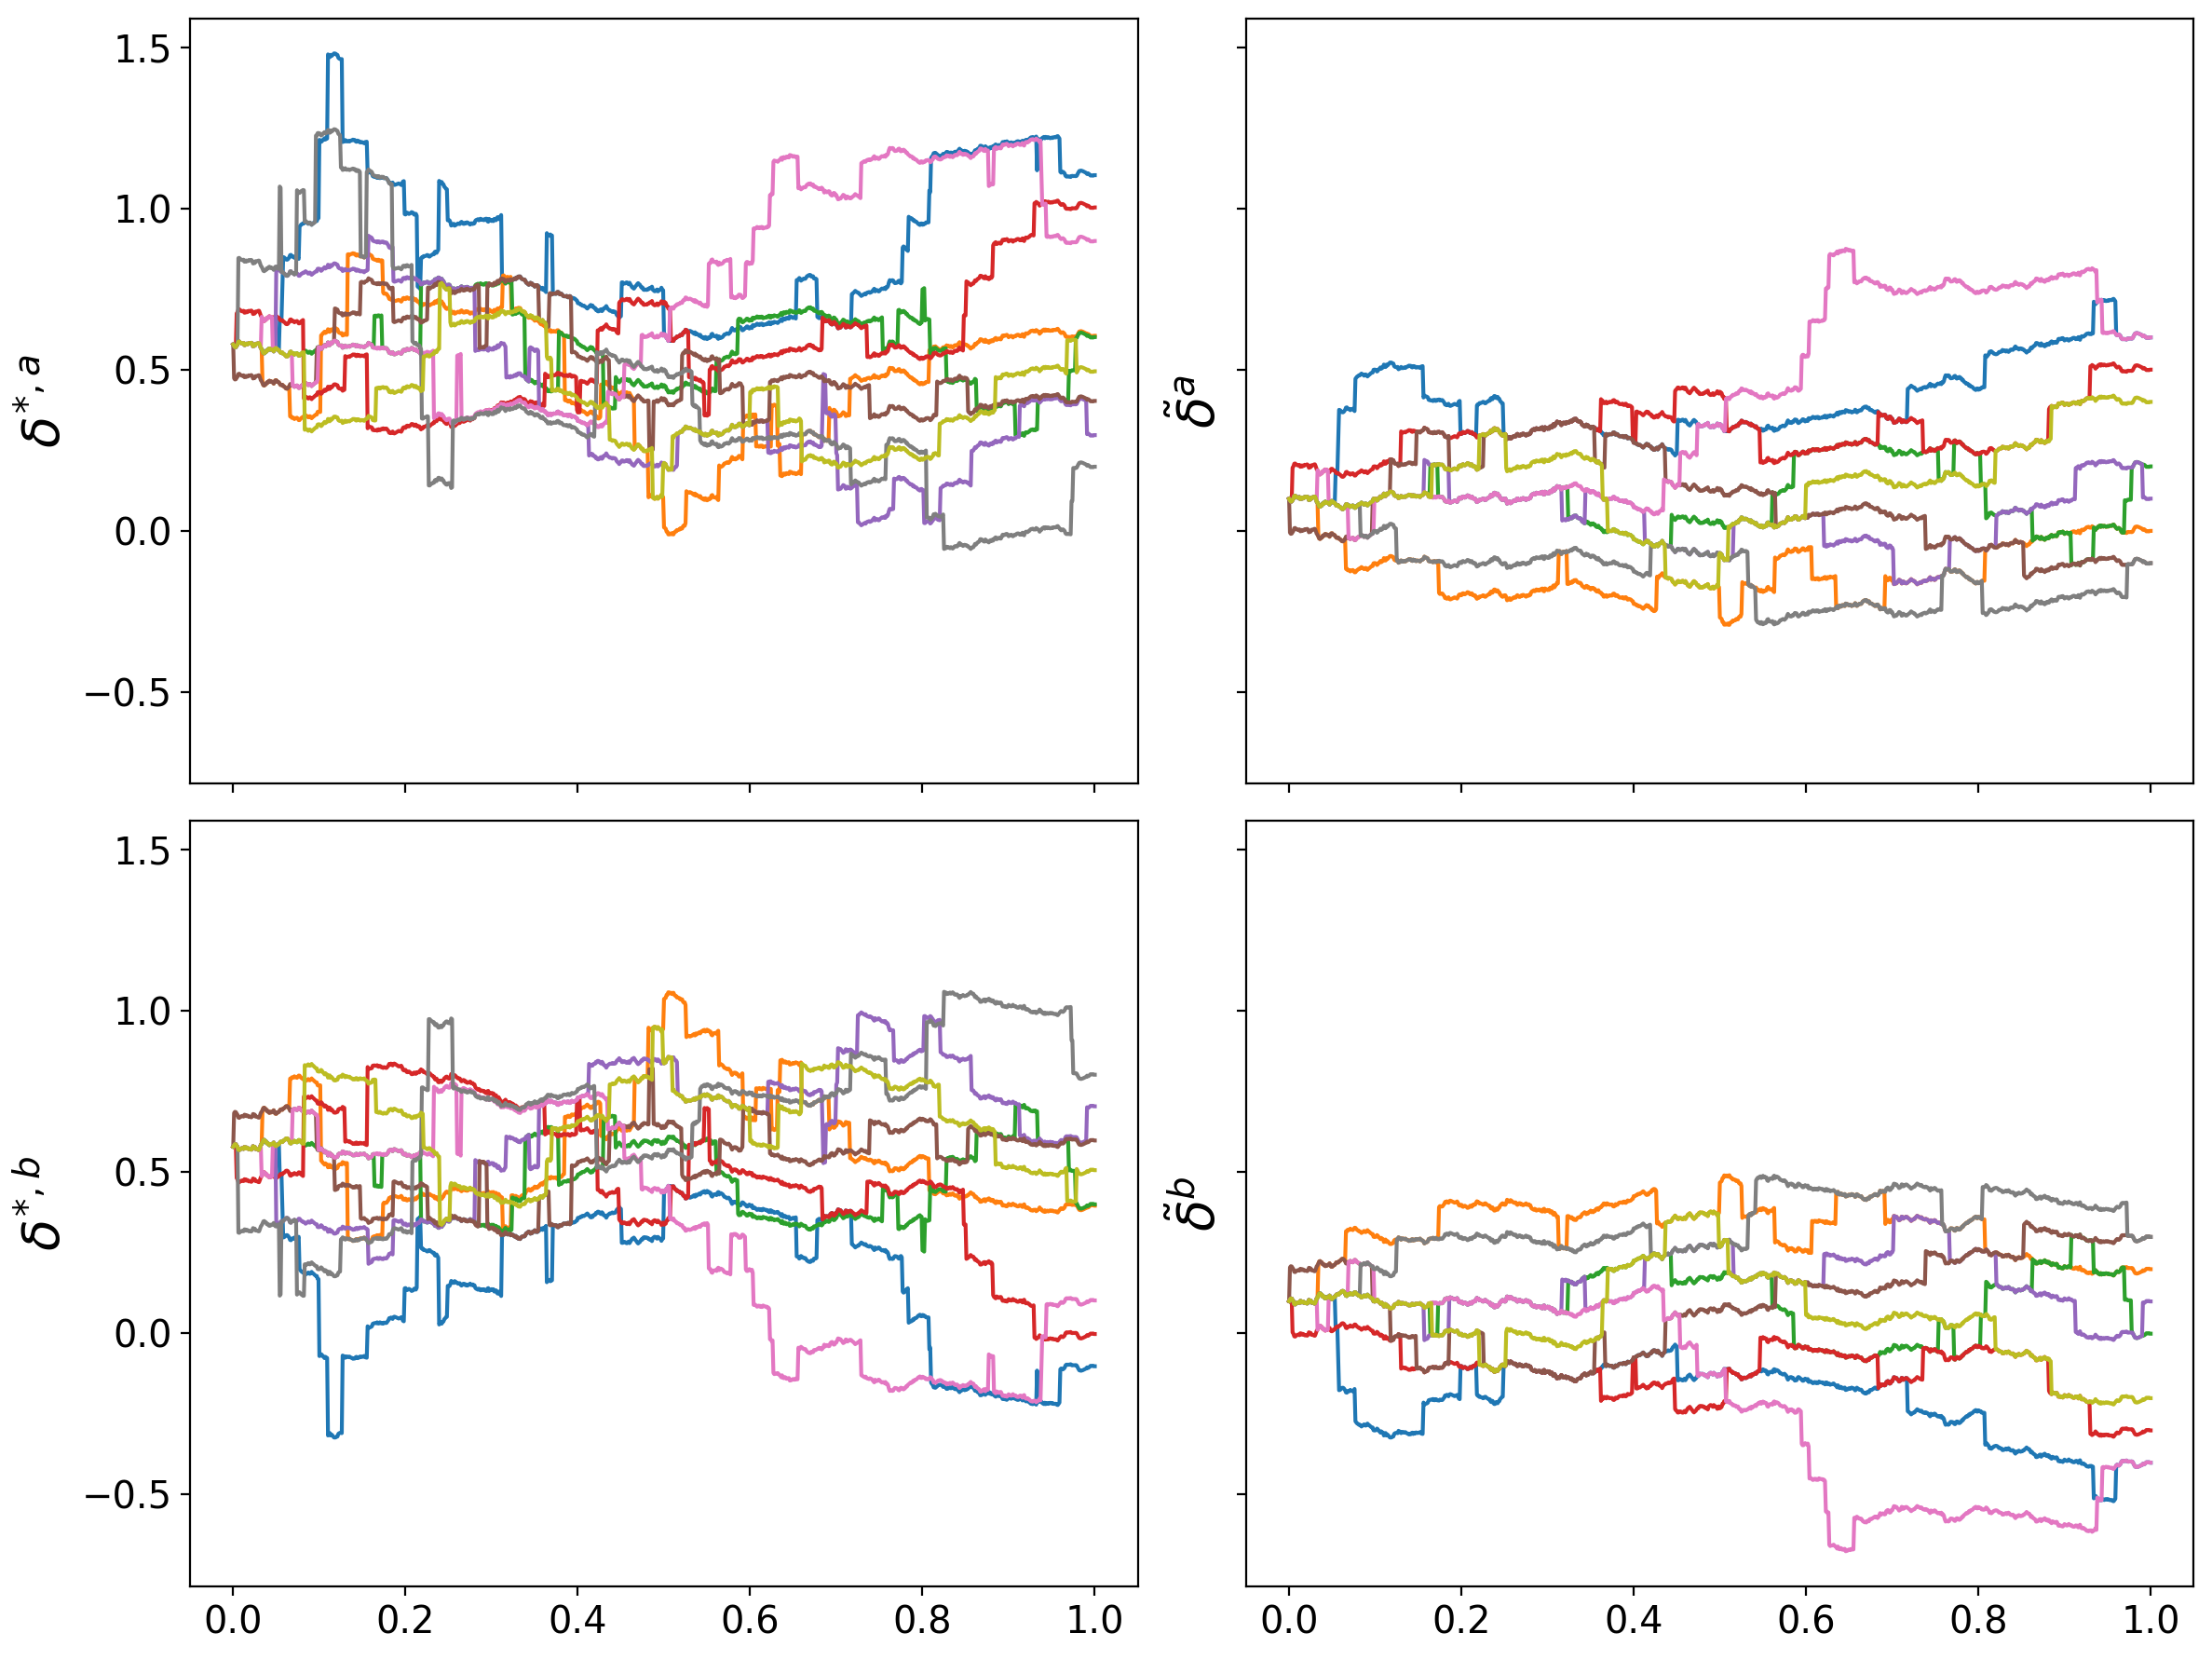

In [19]:
# since final depths never calculated
nmin = 41
nmax = 50
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal D mean = "+str(np.round(np.mean(D[:,-1]),4))+"              Terminal D sd = "+str(np.round(np.std(D[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

print("$Q_{T}$ &"+str(np.round(np.mean(Q[:,-1]),4))+" & "+str(np.round(np.std(Q[:,-1]),4))+" \\\ ")
print("$D_{T}$ &"+str(np.round(np.mean(D[:,-1]),4))+" & "+str(np.round(np.std(D[:,-1]),4))+" \\\ ") 
print("$\mathcal{J}$ &"+str(np.round(np.mean(objective[:]),4))+" & "+str(np.round(np.std(objective[:]),4))+" \\\ ")

fig, ax = plt.subplots(2, 2, figsize = (12,9), sharey=True, sharex=True)
ax[0,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]), label=r'$\delta^{a}$')
ax[0,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]), label=r'$\tilde{\delta}^{a}$')
ax[1,0].plot(time, np.transpose(deltas_b[nmin:nmax,:]), label=r'$\delta^{b}$')
ax[1,1].plot(time, np.transpose(tildes_b[nmin:nmax,:]), label=r'$\tilde{\delta}^{a}$')
ax[0,0].set_ylabel(r'$\delta^{*,a}$', fontsize = 20)
ax[0,1].set_ylabel(r'$\tilde{\delta}^{a}$', fontsize = 20)
ax[1,0].set_ylabel(r'$\delta^{*,b}$', fontsize = 20)
ax[1,1].set_ylabel(r'$\tilde{\delta}^{b}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('figures/q_d_deltas_tildes.pdf', format="pdf", dpi=dpi)
plt.show()



Terminal Q mean = -0.038              Terminal Q sd = 1.4888
Terminal D mean = 0.346              Terminal D sd = 3.7438
Terminal X mean = 8.3995            Terminal X sd = 148.294
Terminal PnL mean = 4.6376           Terminal PnL sd = 2.815
Terminal objective mean = 4.3579     Terminal objective sd = 2.8494
$Q_{T}$ &-0.038 & 1.4888 \\ 
$D_{T}$ &0.346 & 3.7438 \\ 
$\mathcal{J}$ &4.3579 & 2.8494 \\ 


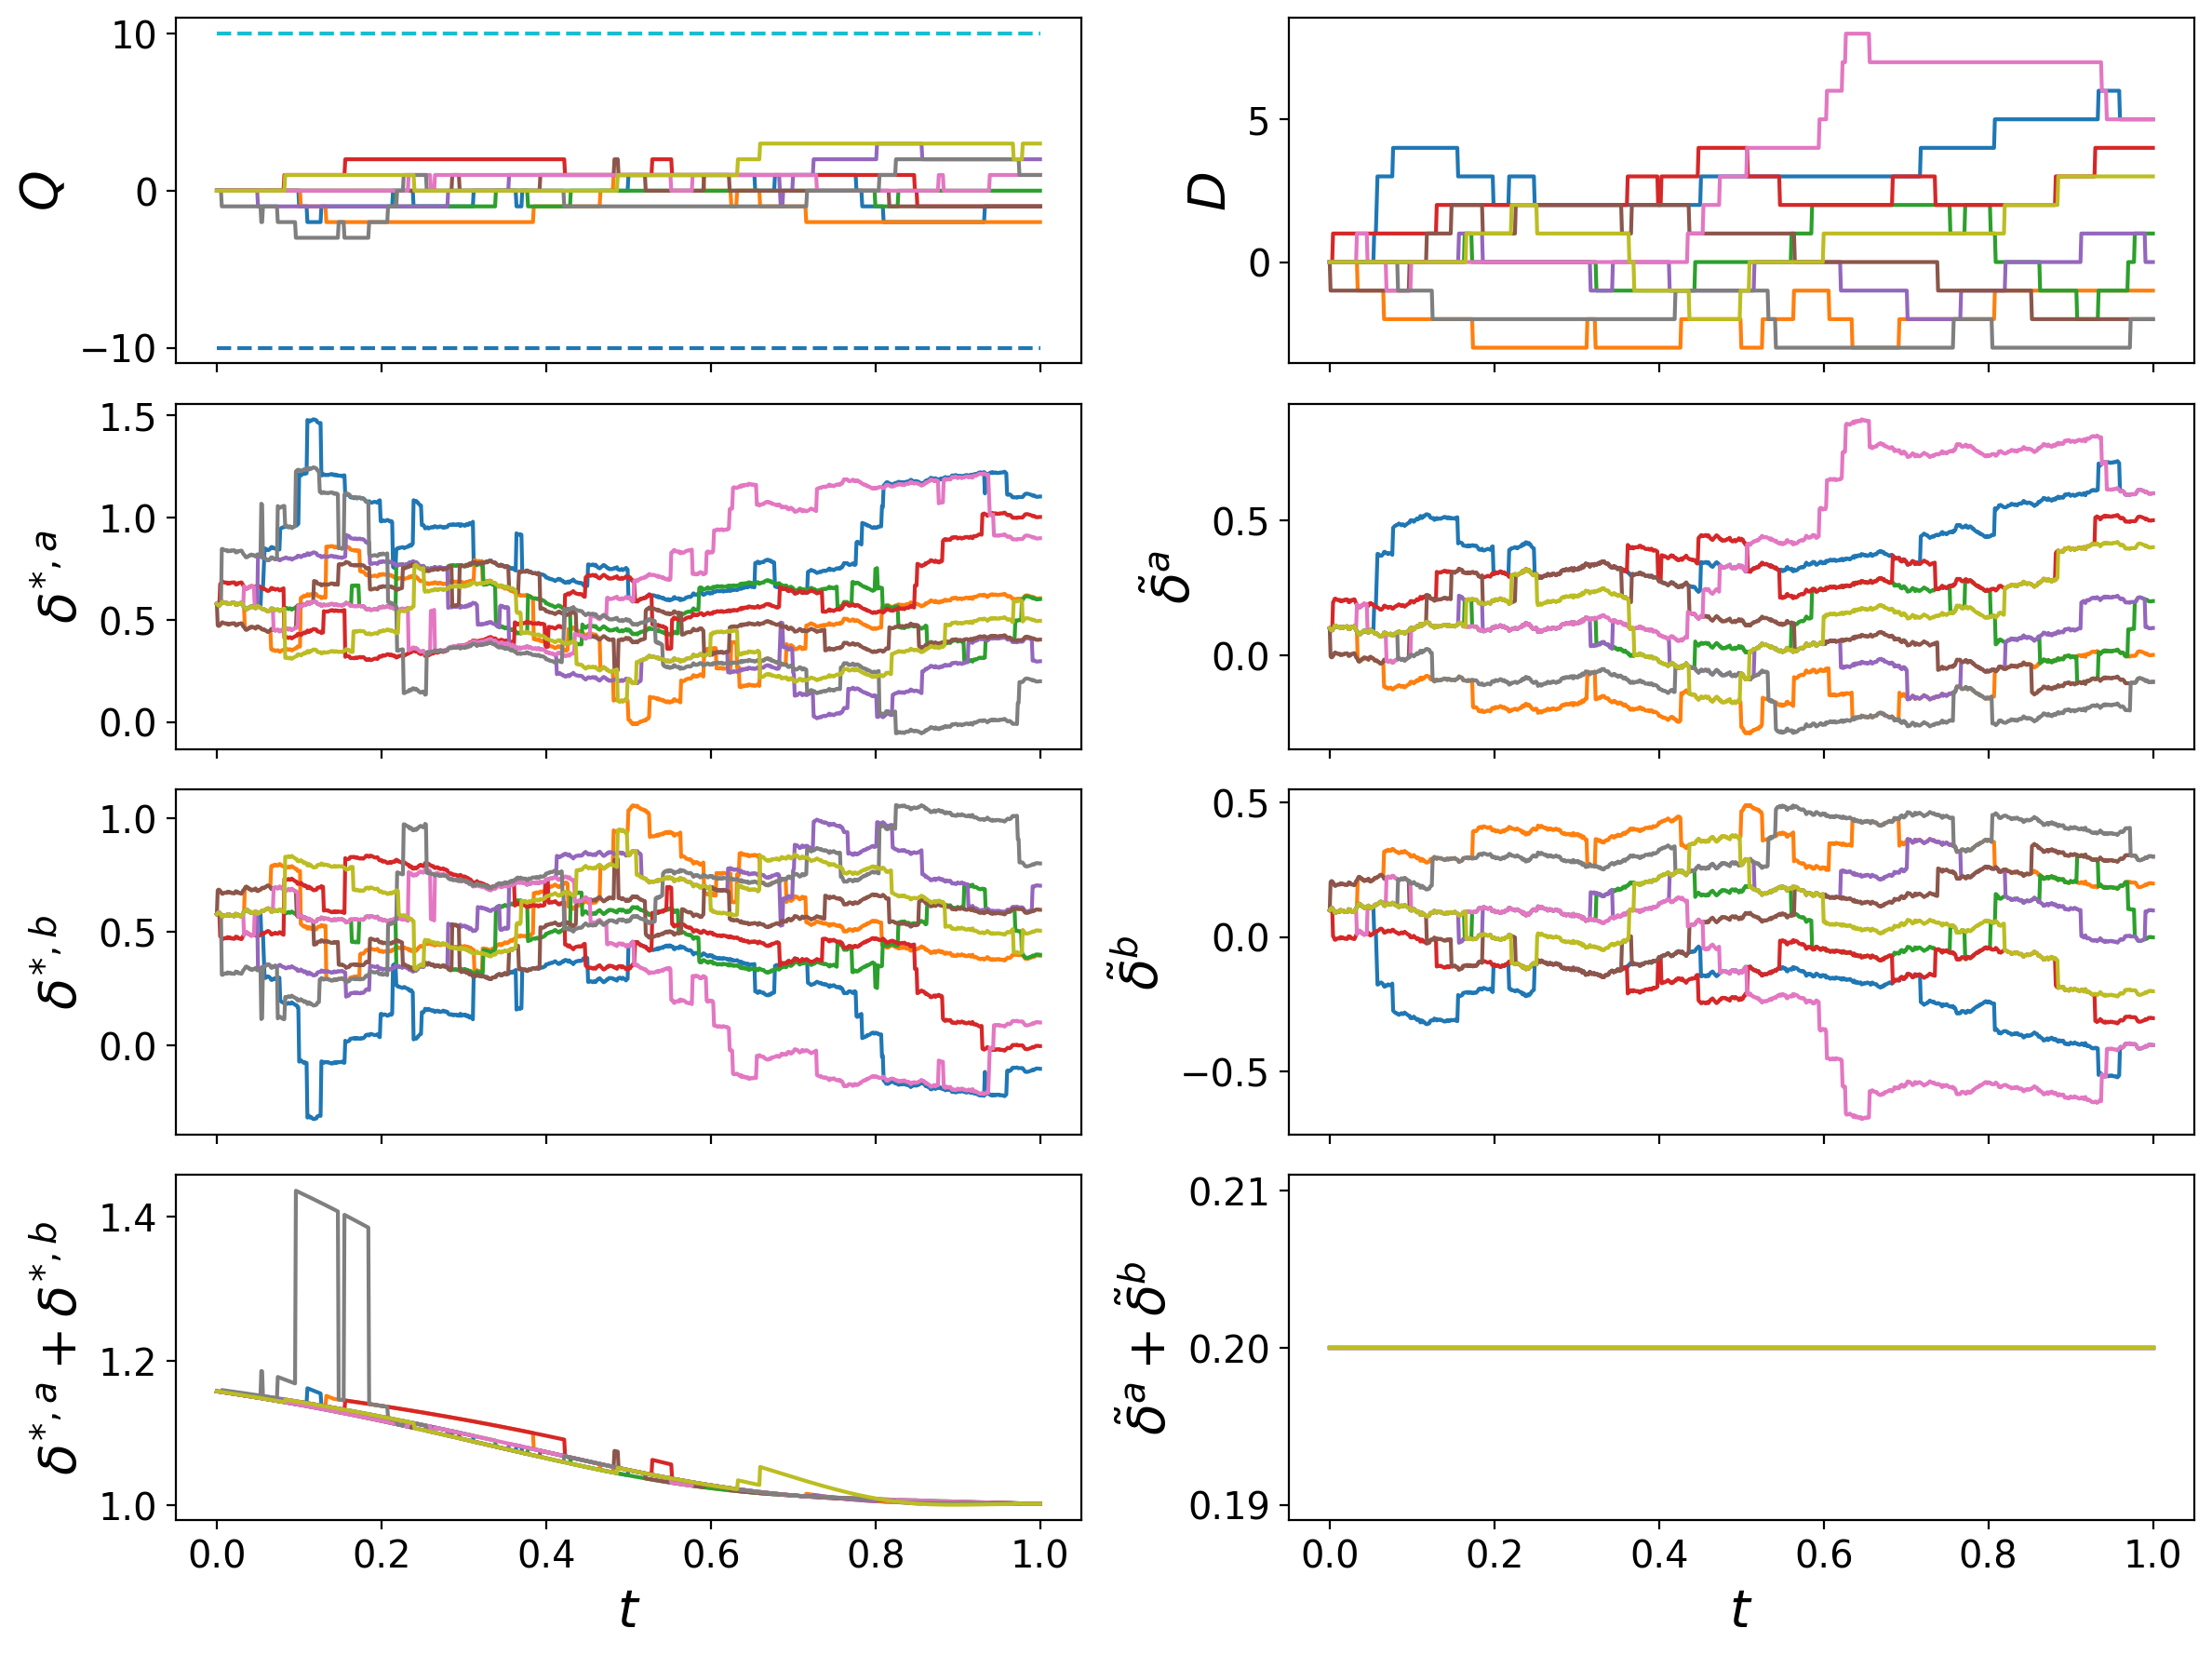

In [20]:
# since final depths never calculated
nmin = 41
nmax = 50
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal D mean = "+str(np.round(np.mean(D[:,-1]),4))+"              Terminal D sd = "+str(np.round(np.std(D[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

print("$Q_{T}$ &"+str(np.round(np.mean(Q[:,-1]),4))+" & "+str(np.round(np.std(Q[:,-1]),4))+" \\\ ")
print("$D_{T}$ &"+str(np.round(np.mean(D[:,-1]),4))+" & "+str(np.round(np.std(D[:,-1]),4))+" \\\ ") 
print("$\mathcal{J}$ &"+str(np.round(np.mean(objective[:]),4))+" & "+str(np.round(np.std(objective[:]),4))+" \\\ ")

fig, ax = plt.subplots(4, 2, figsize = (12,9), sharey=False, sharex=True)
ax[0,0].plot(time, np.transpose(Q[nmin:nmax,:]))
ax[0,1].plot(time, np.transpose(D[nmin:nmax,:]))
ax[0,0].plot(time, np.repeat(qmax, len(time)), '--')
ax[0,0].plot(time, np.repeat(qmin, len(time)), '--')
ax[1,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]), label=r'$\delta^{a}$')
ax[1,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]), label=r'$\tilde{\delta}^{a}$')
ax[2,0].plot(time, np.transpose(deltas_b[nmin:nmax,:]), label=r'$\delta^{b}$')
ax[2,1].plot(time, np.transpose(tildes_b[nmin:nmax,:]), label=r'$\tilde{\delta}^{a}$')
ax[3,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]+deltas_b[nmin:nmax,:]), label='Reference spread')
ax[3,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]+tildes_b[nmin:nmax,:]), label='Competition spread')
#ax[0].set_title("Reference MM's inventory", **tnrfont)
#ax[1].set_title("Pooled competition's inventory", **tnrfont)
ax[3,0].set_xlabel(r'$t$', fontsize = 20)
ax[3,1].set_xlabel(r'$t$', fontsize = 20)
ax[0,0].set_ylabel(r'$Q$', fontsize = 20)
ax[0,1].set_ylabel(r'$D$', fontsize = 20)
ax[1,0].set_ylabel(r'$\delta^{*,a}$', fontsize = 20)
ax[1,1].set_ylabel(r'$\tilde{\delta}^{a}$', fontsize = 20)
ax[2,0].set_ylabel(r'$\delta^{*,b}$', fontsize = 20)
ax[2,1].set_ylabel(r'$\tilde{\delta}^{b}$', fontsize = 20)
ax[3,0].set_ylabel(r'$\delta^{*,a}+\delta^{*,b}$', fontsize = 20)
ax[3,1].set_ylabel(r'$\tilde{\delta}^{a}+\tilde{\delta}^{b}$', fontsize = 20)
plt.tight_layout()
#plt.savefig('figures/q_d_deltas_tildes.pdf', format="pdf", dpi=dpi)
plt.show()



In [21]:
deltas_a = np.round(deltas_a[:,:], 3) - eta
deltas_b = np.round(deltas_b[:,:], 3) - eta
tildes_a = np.round(tildes_a[:,:], 3) 
tildes_b = np.round(tildes_b[:,:], 3) 
S = np.round(S, 3)

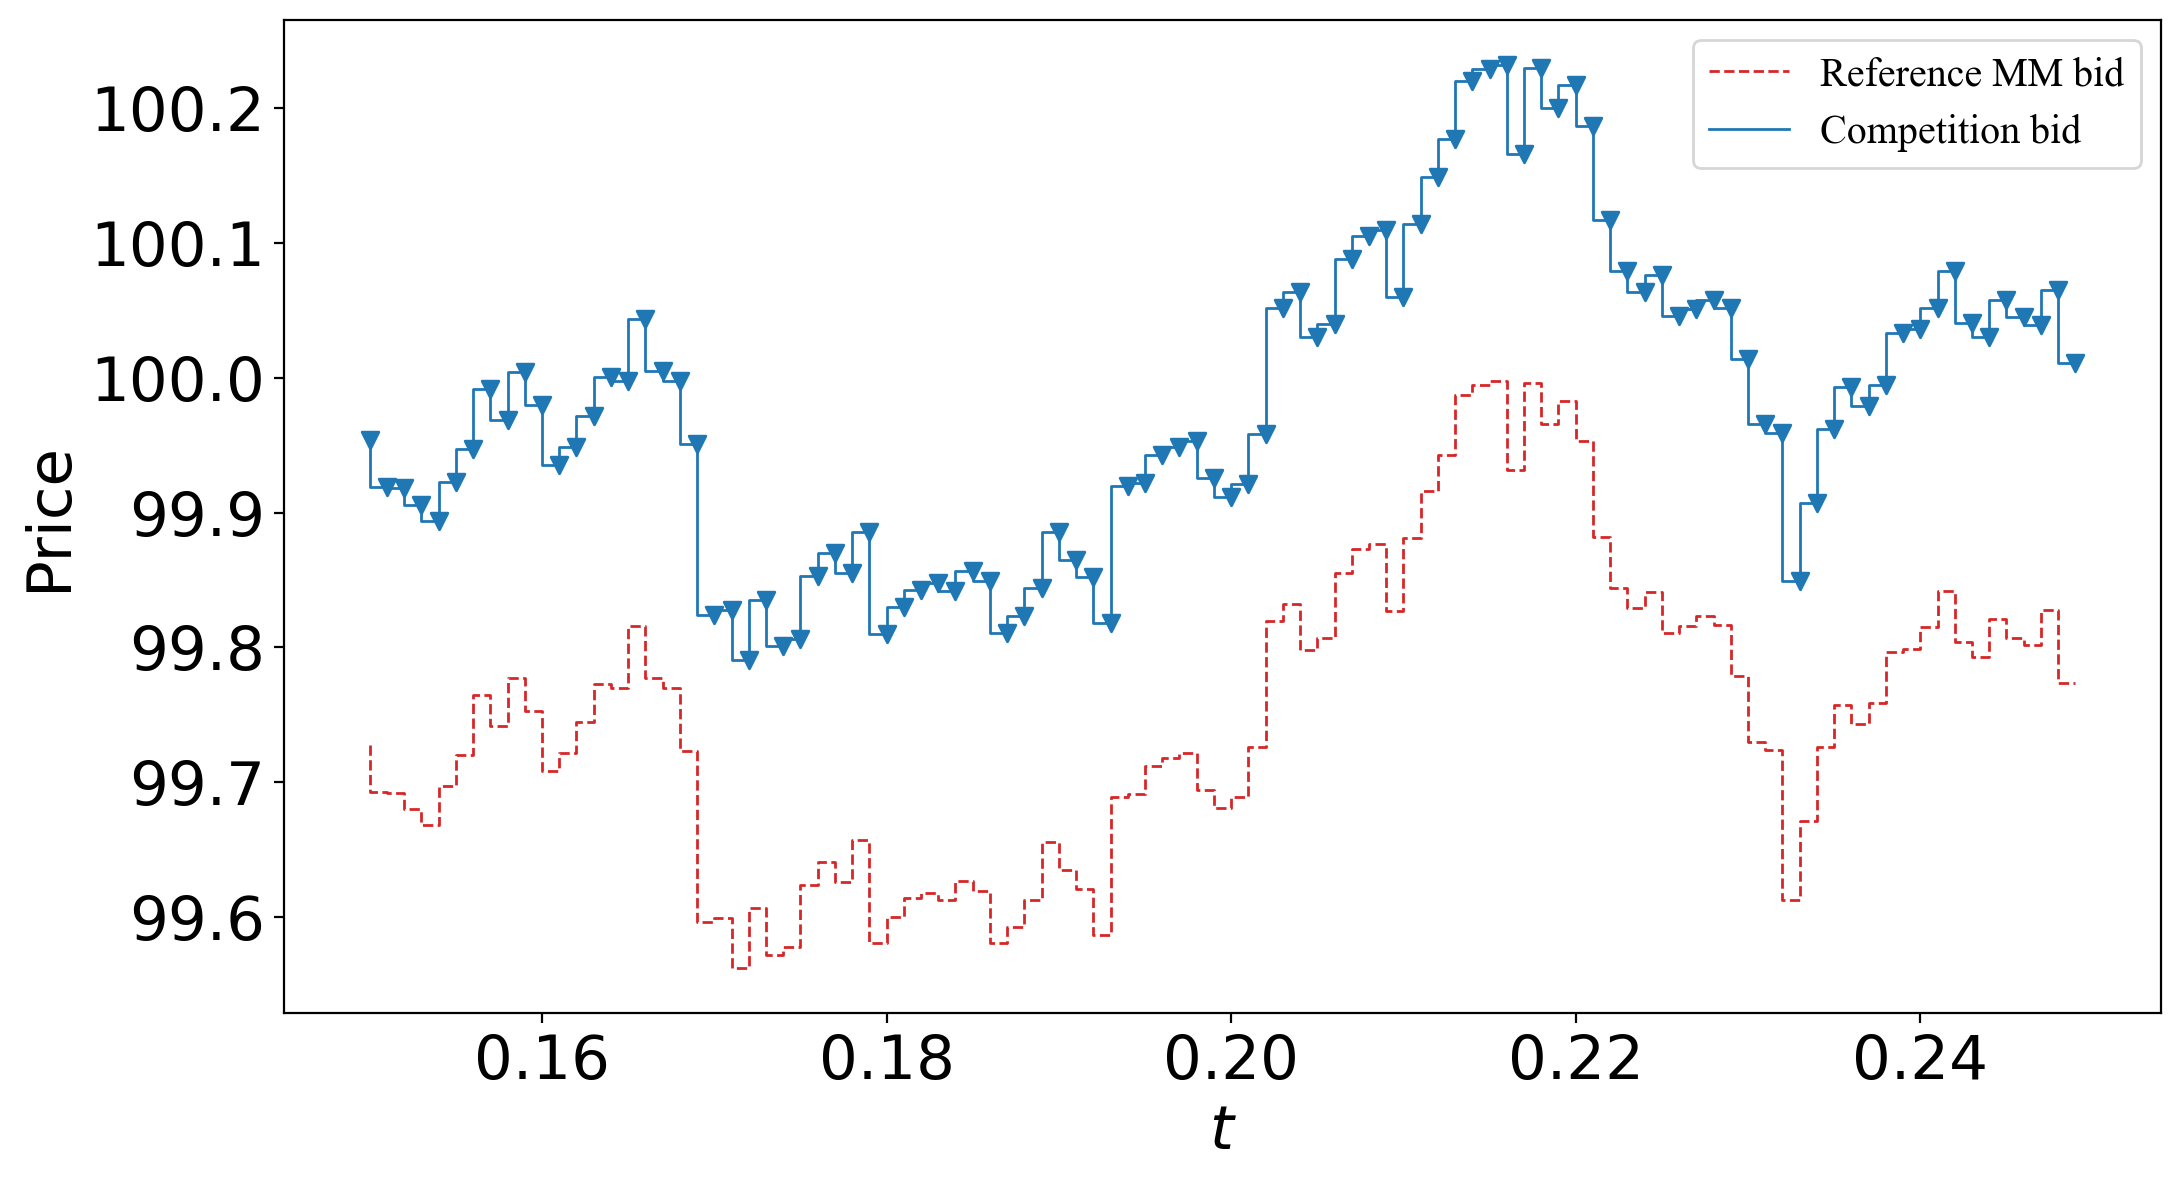

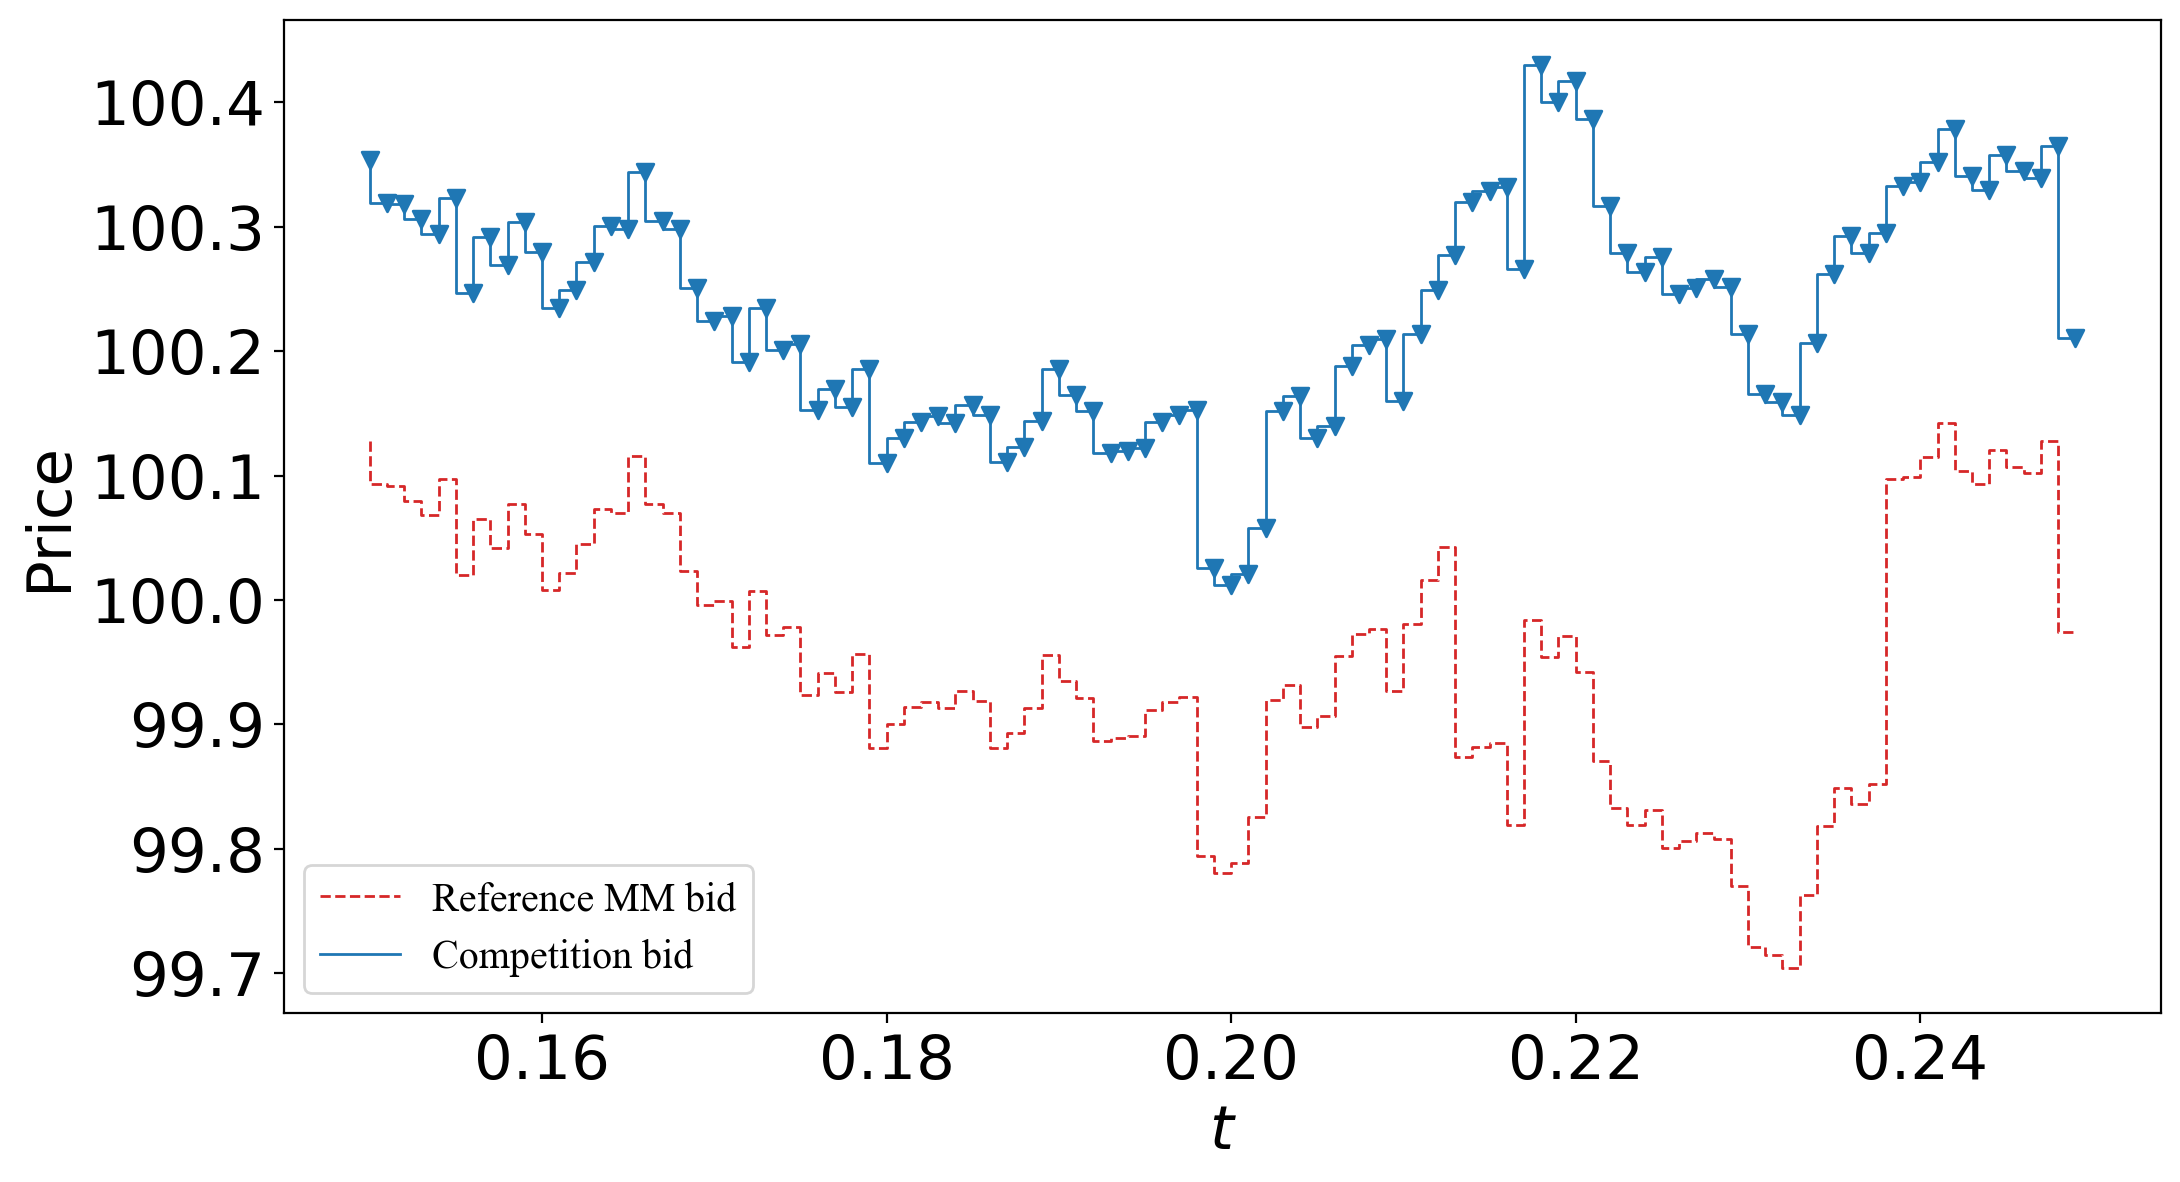

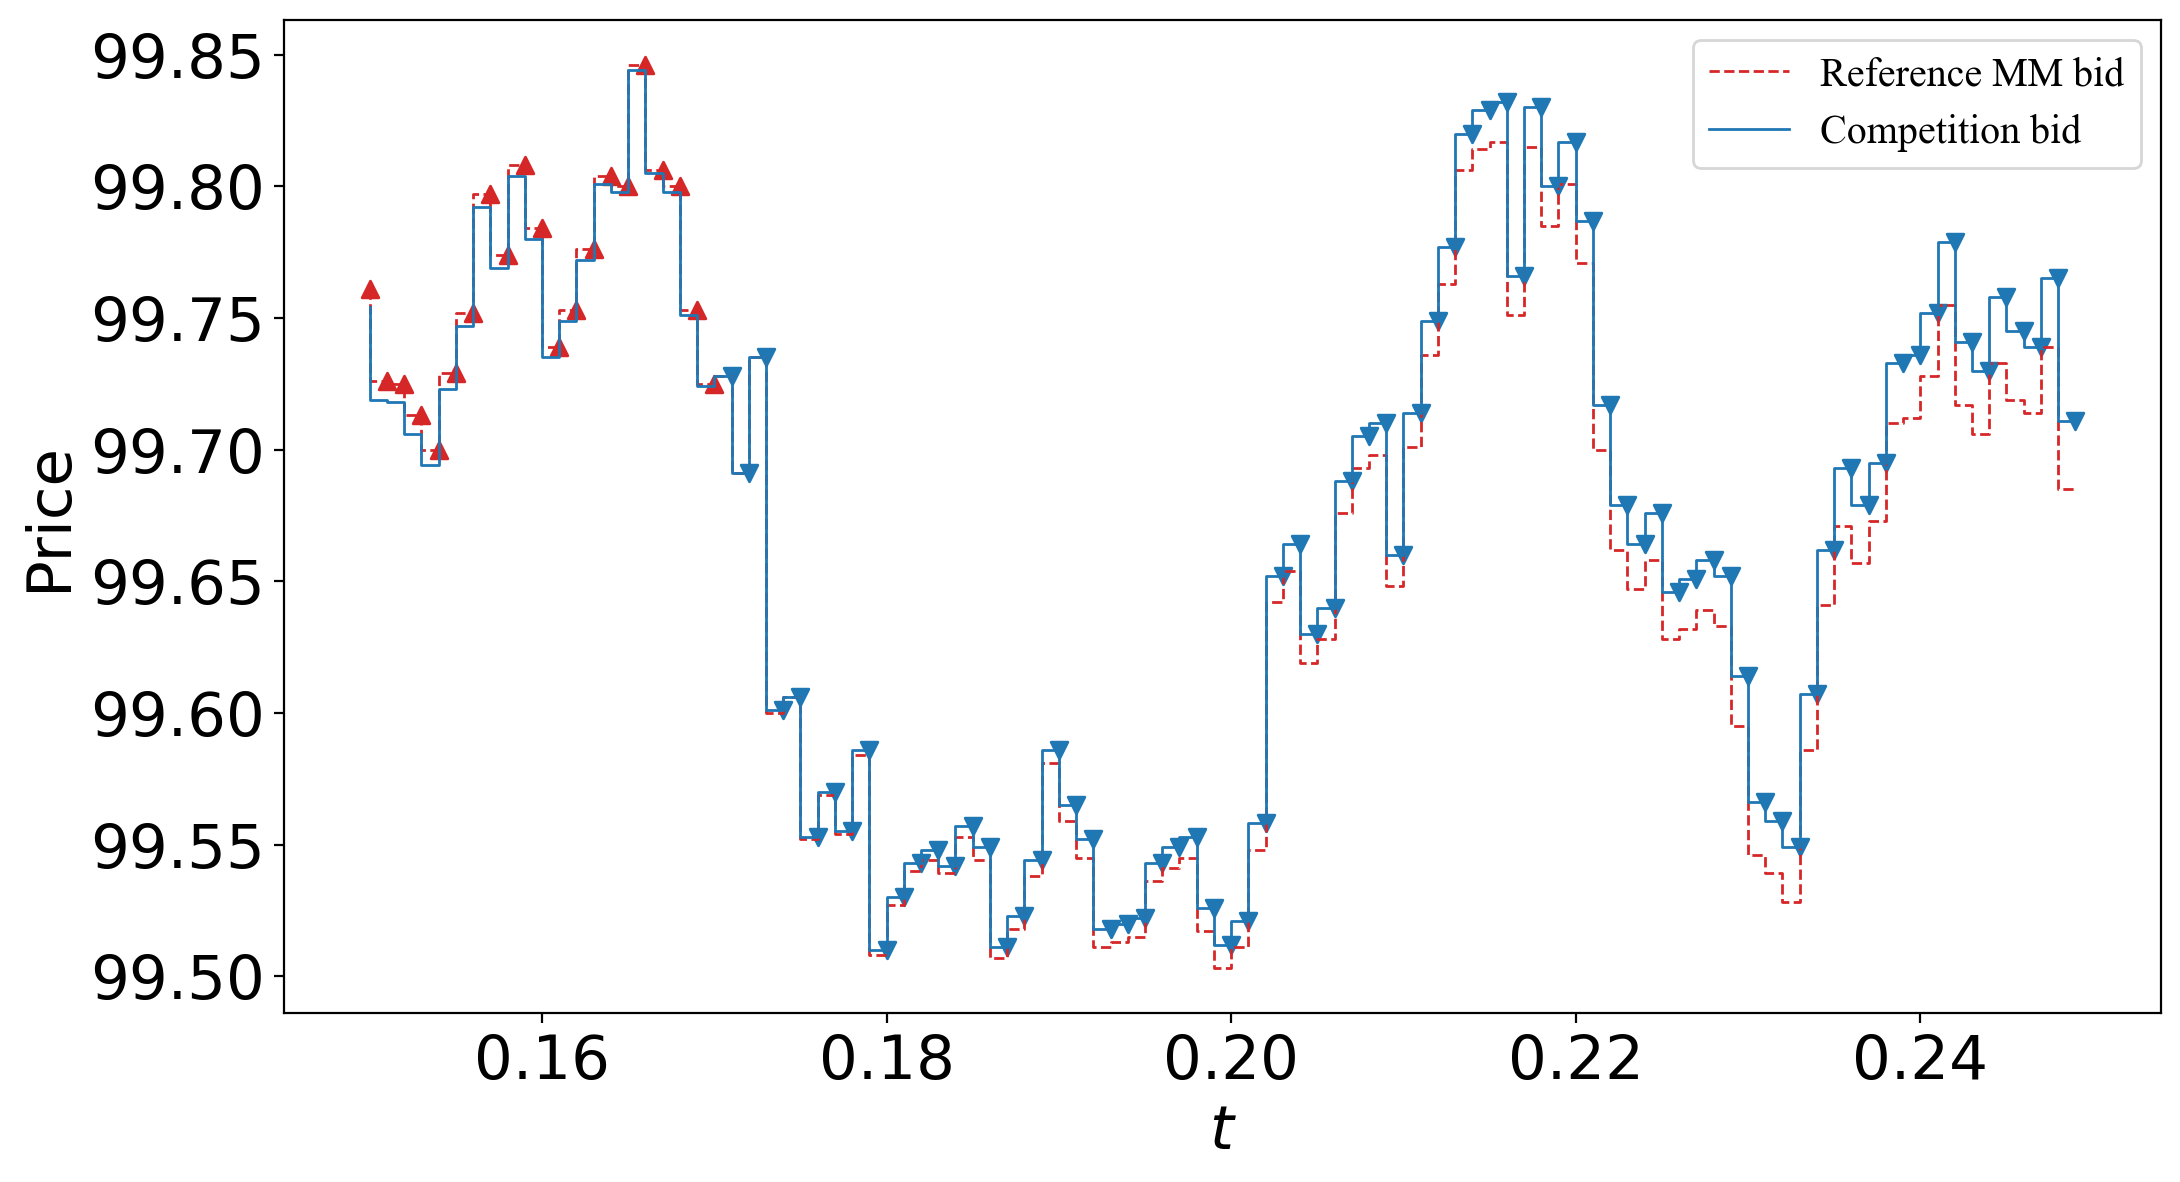

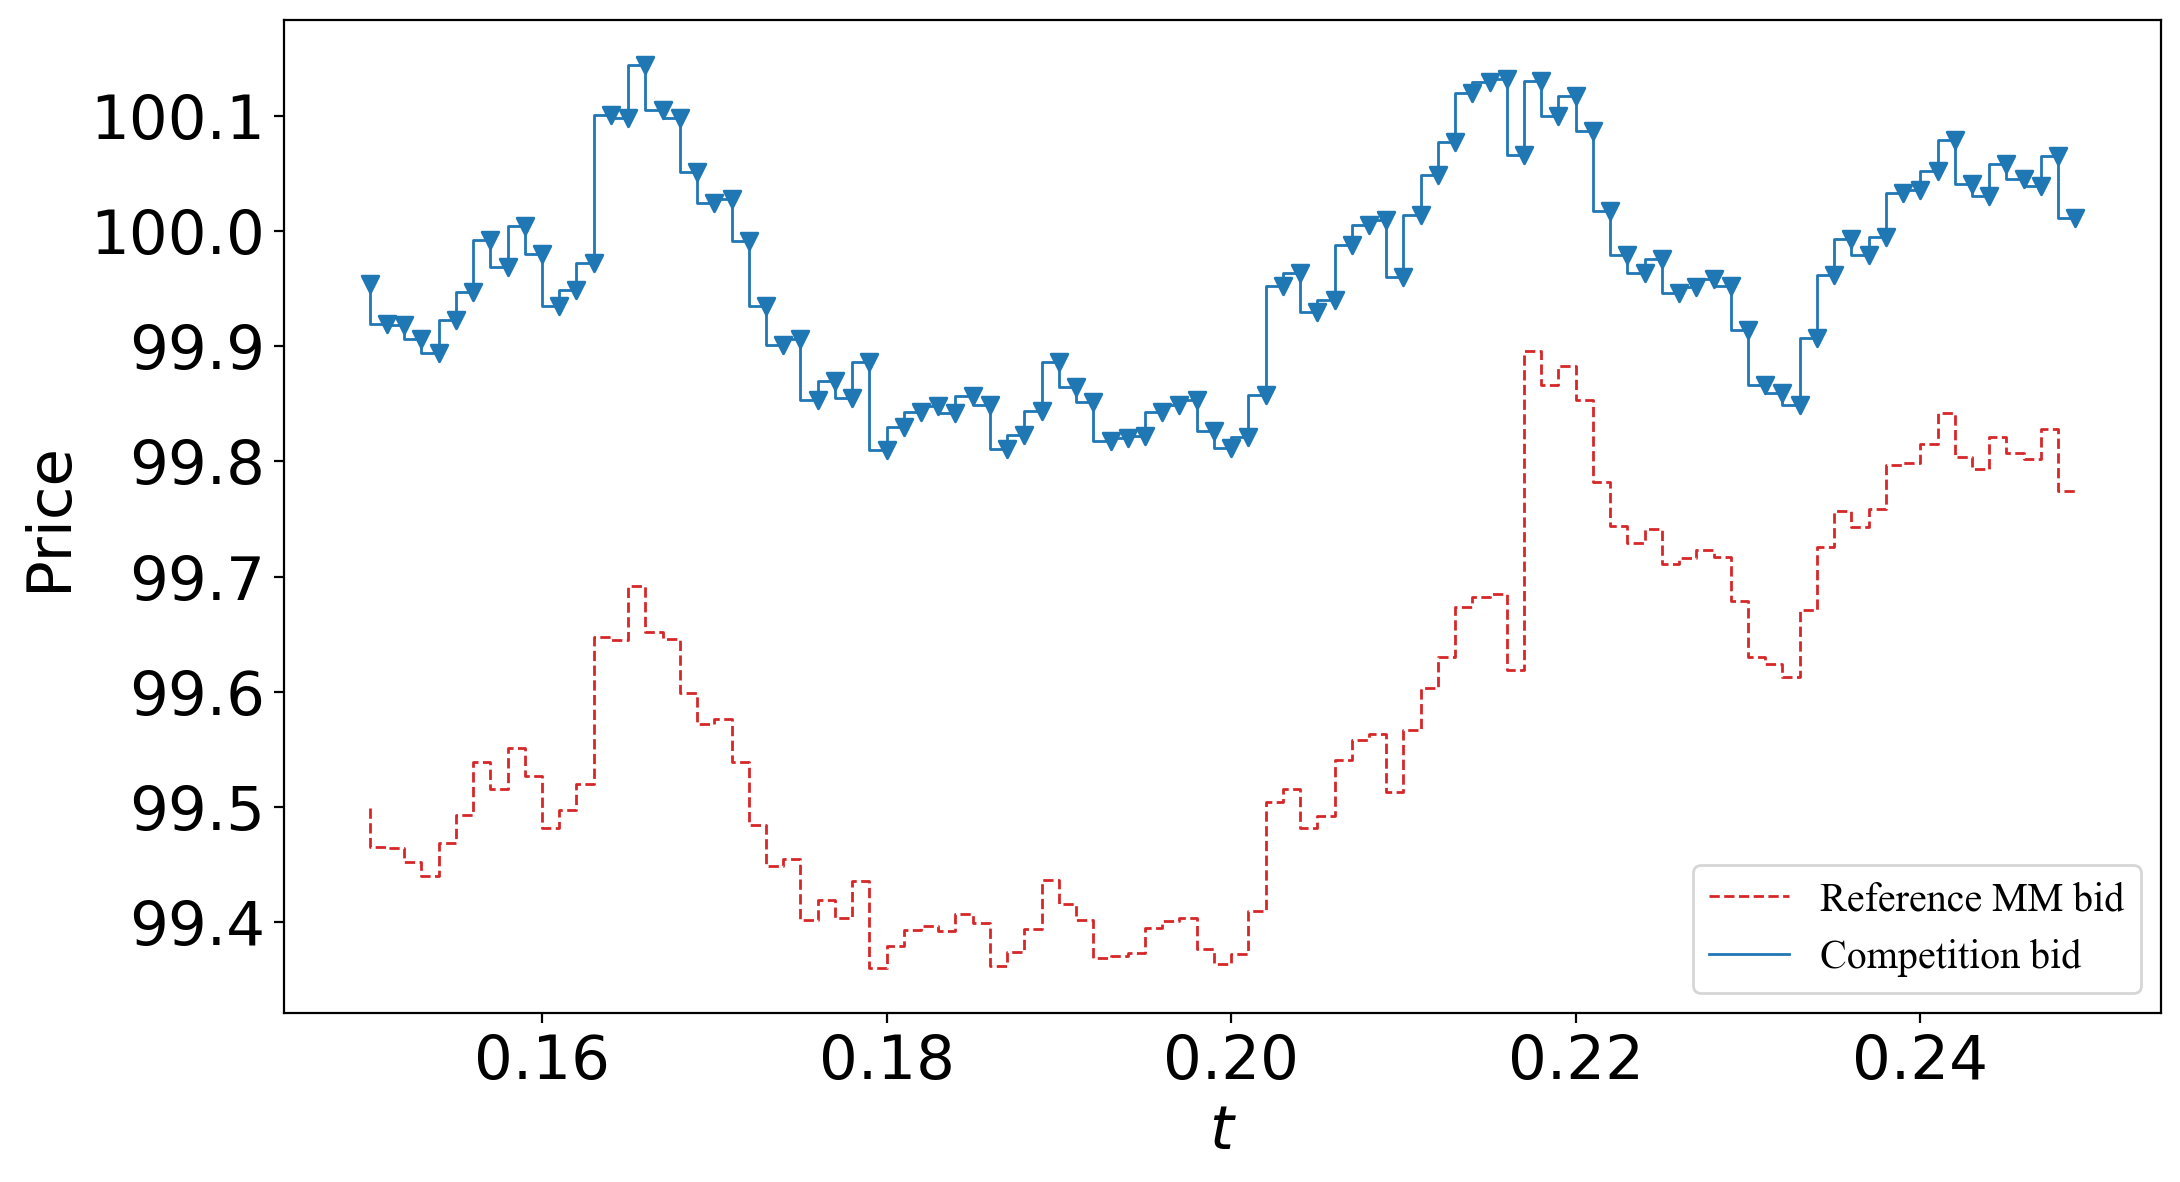

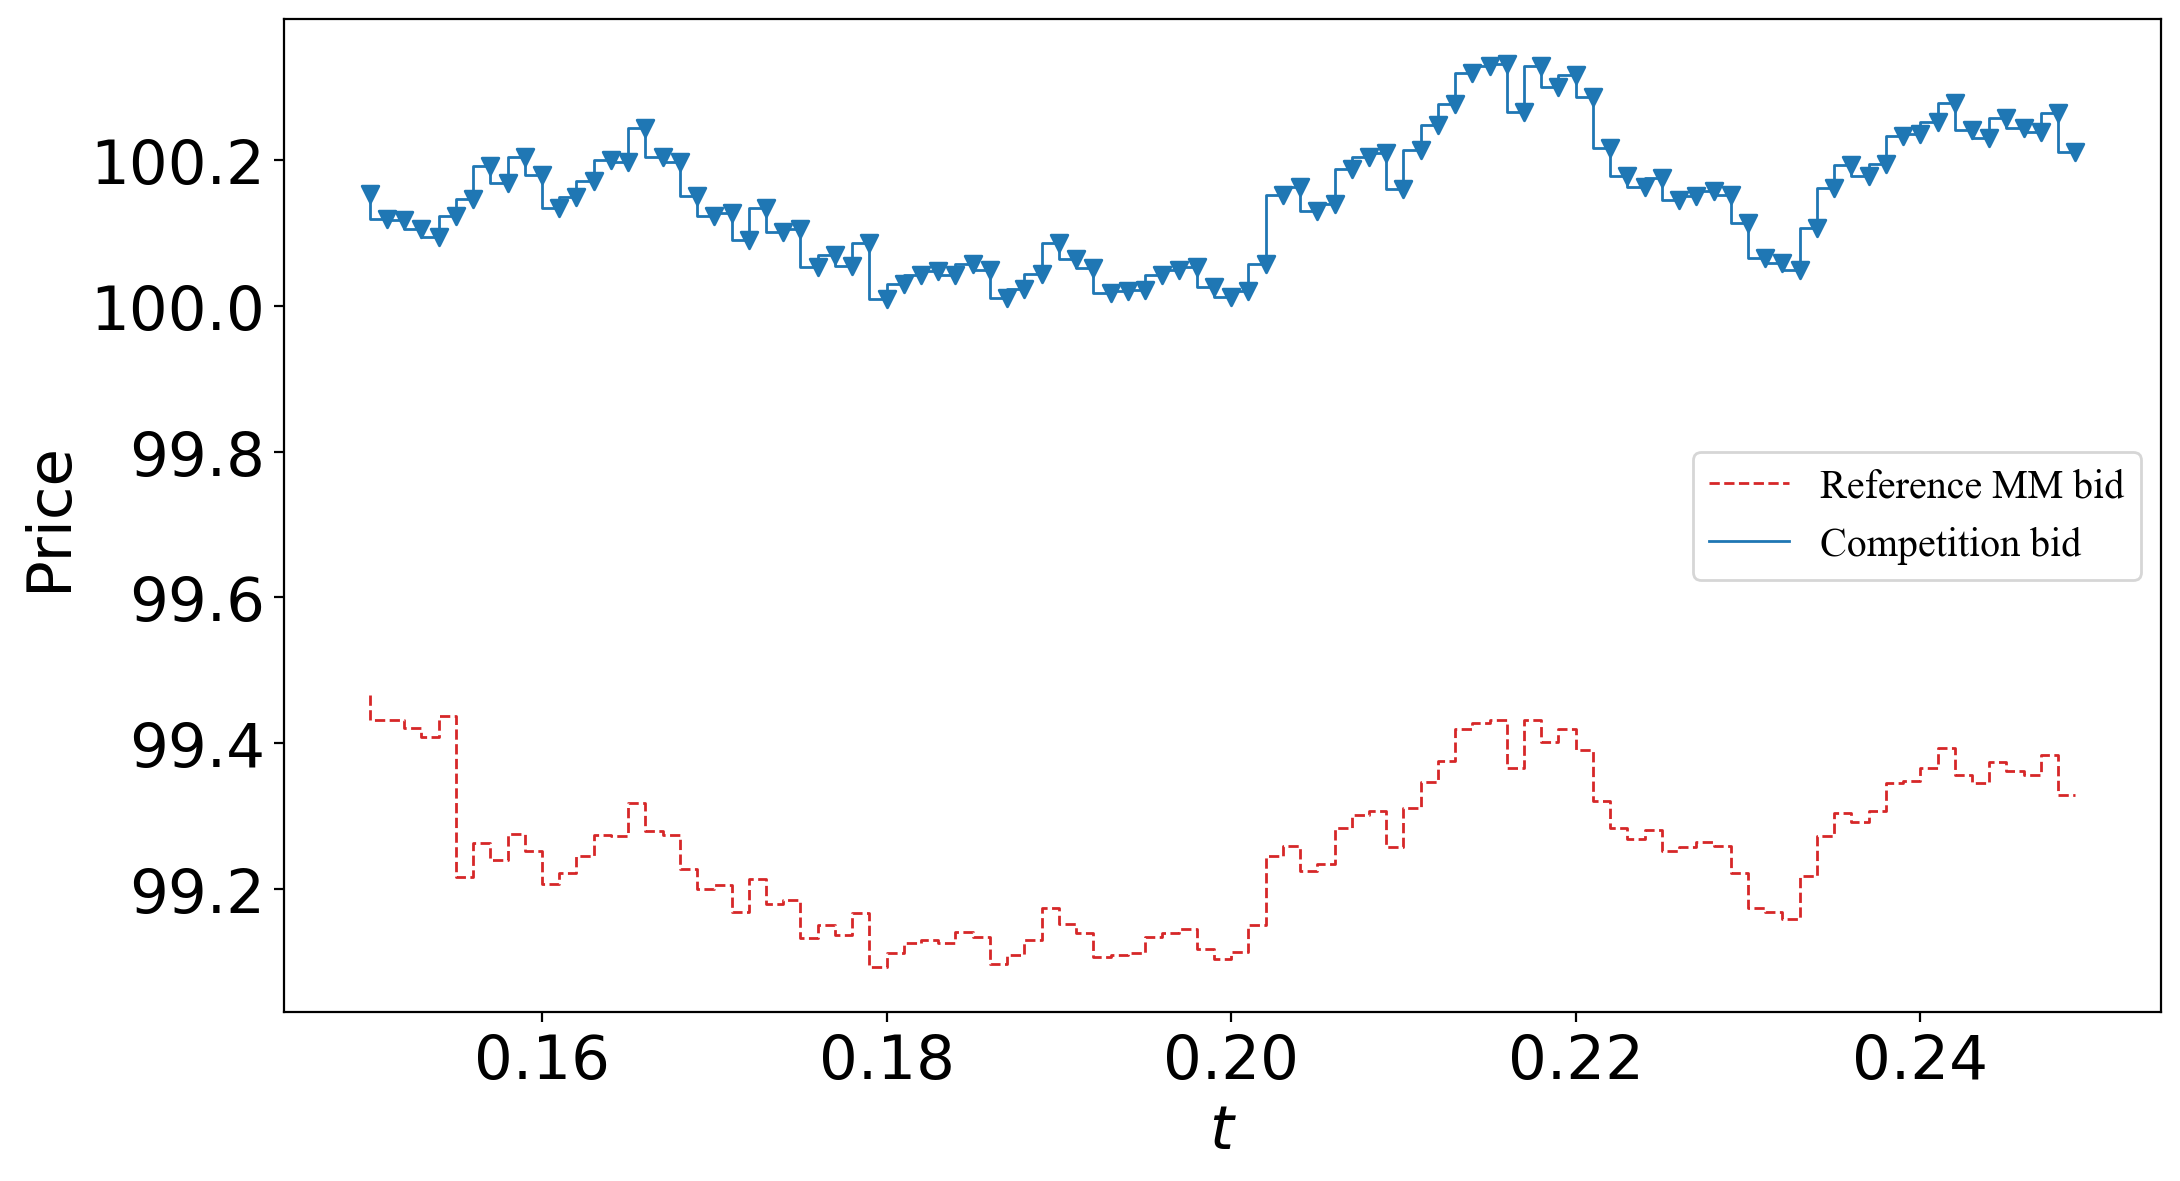

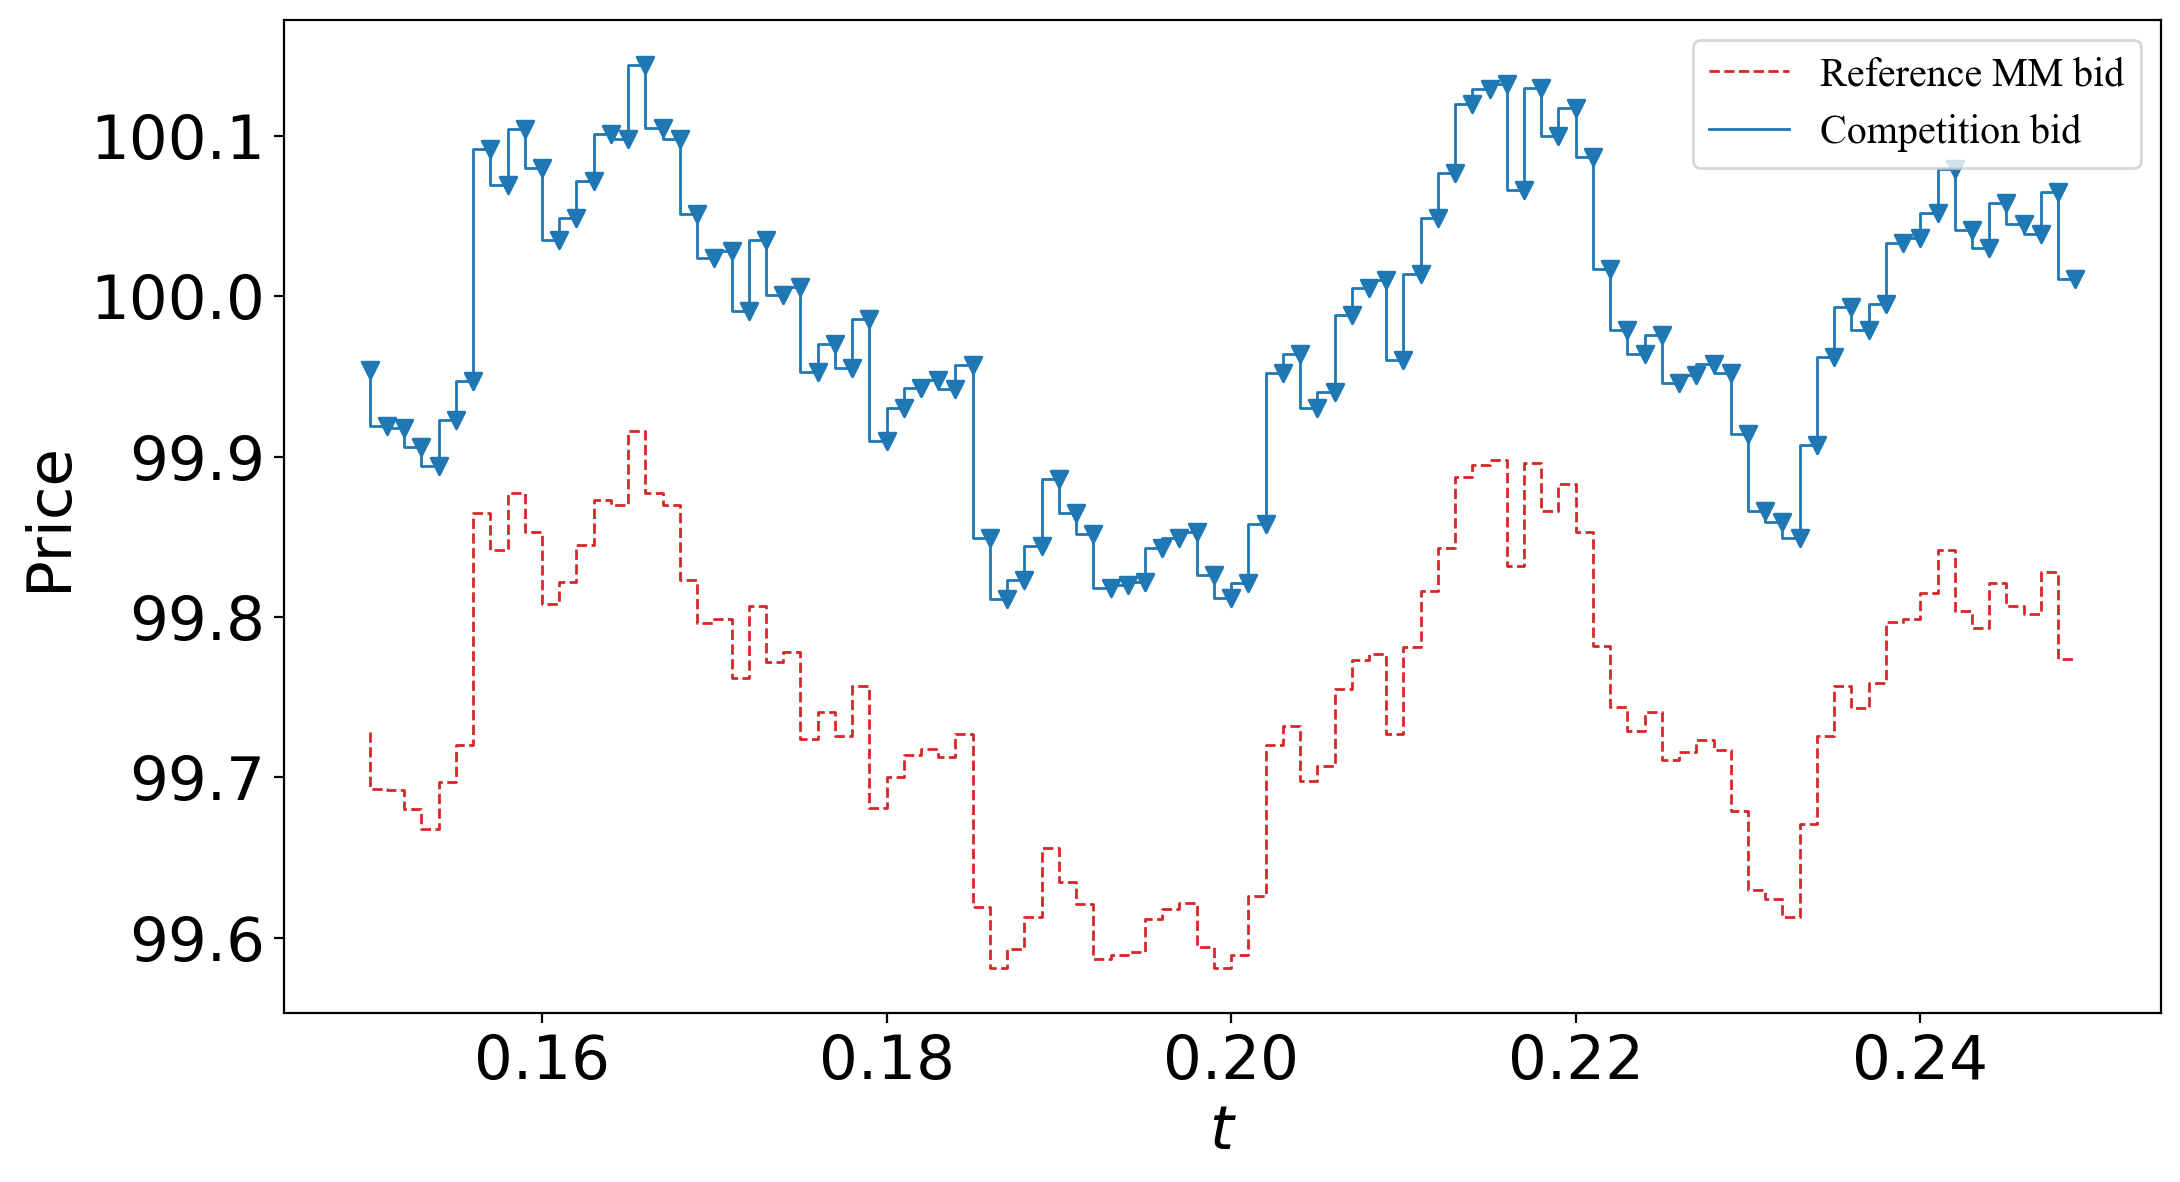

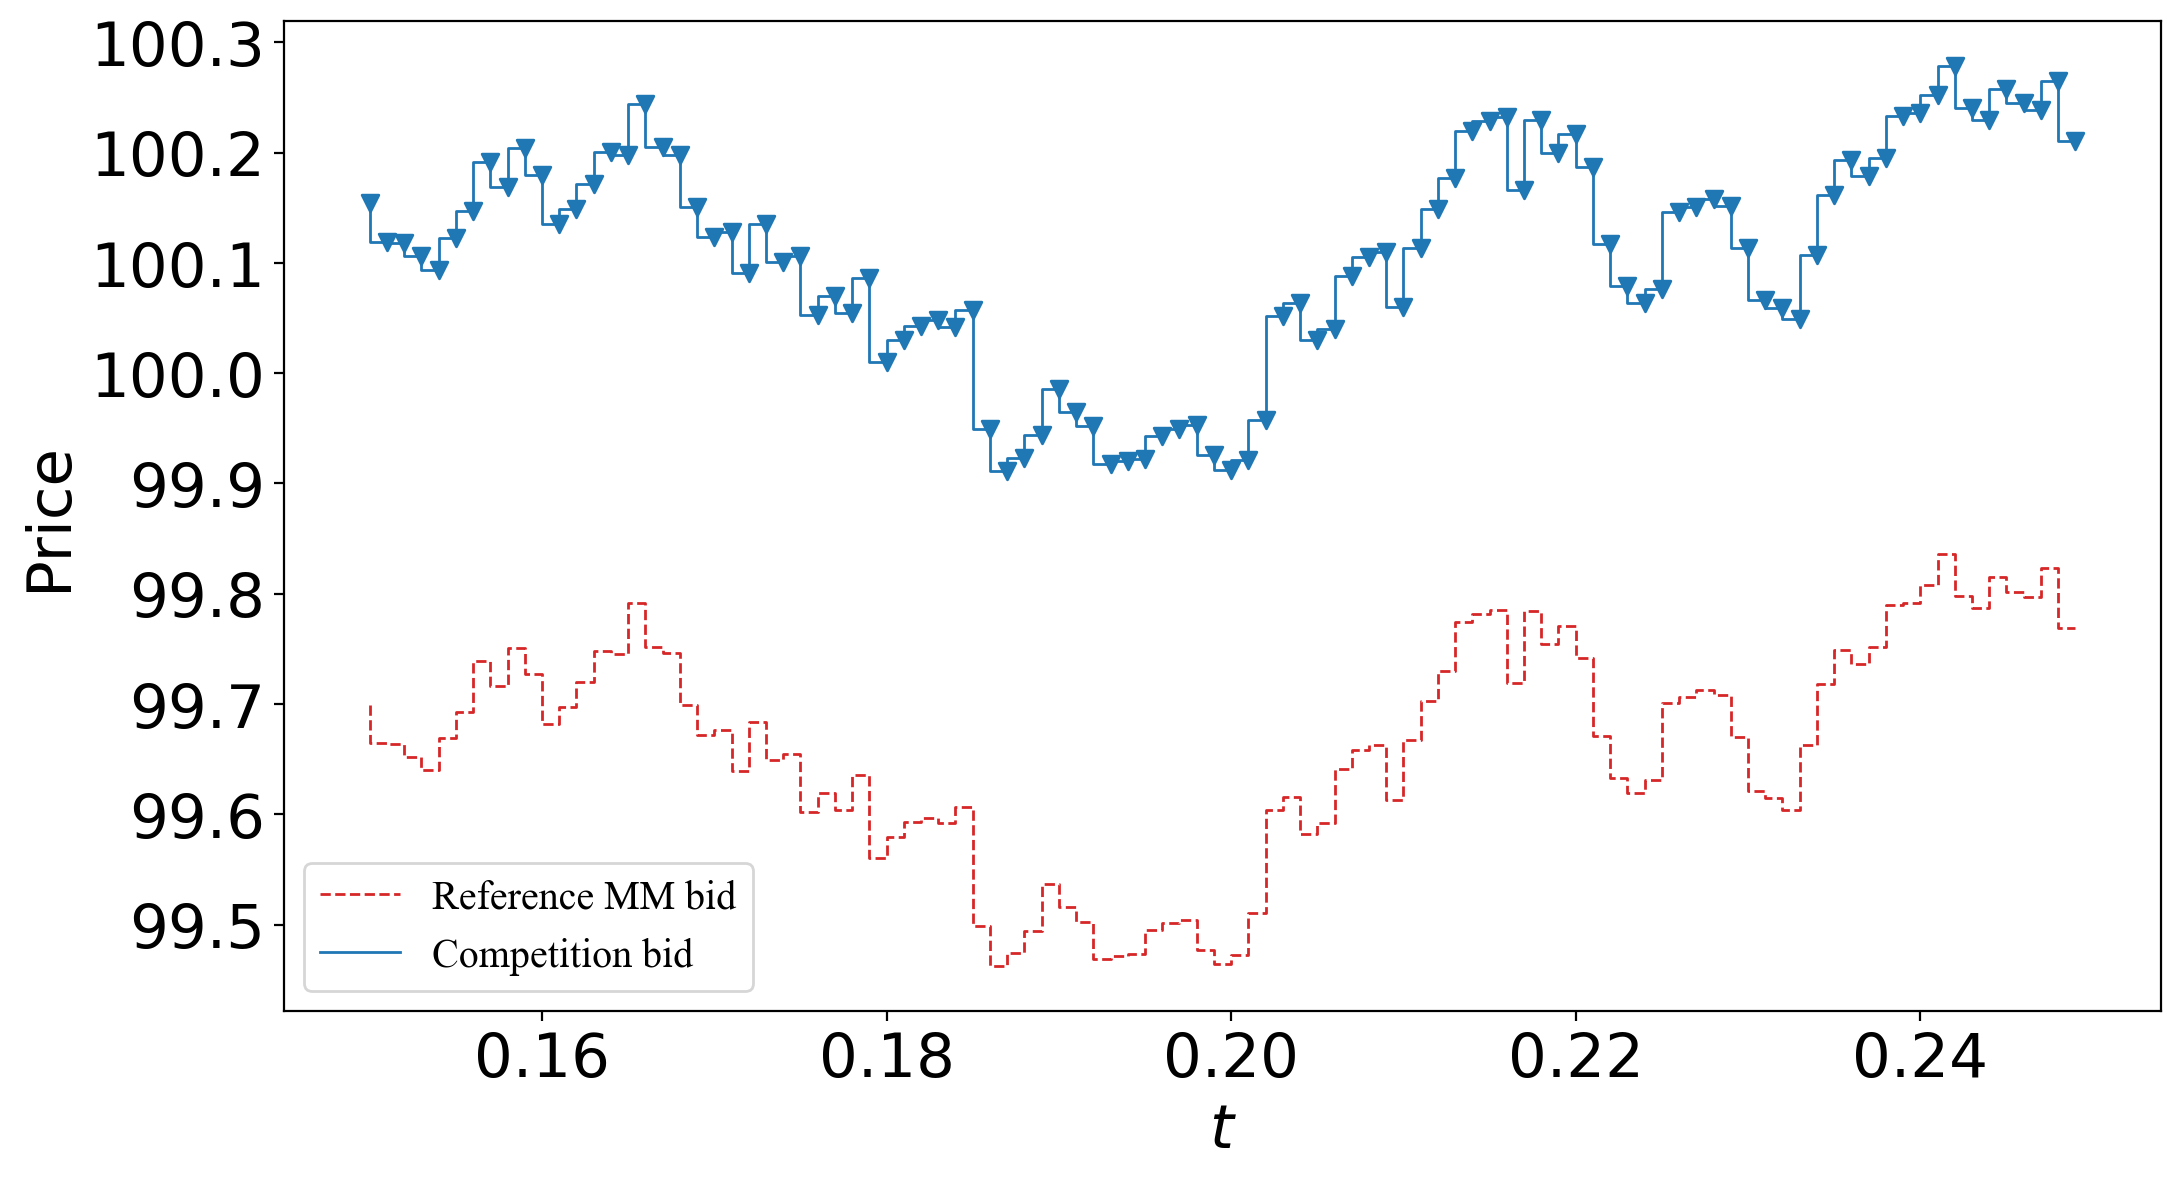

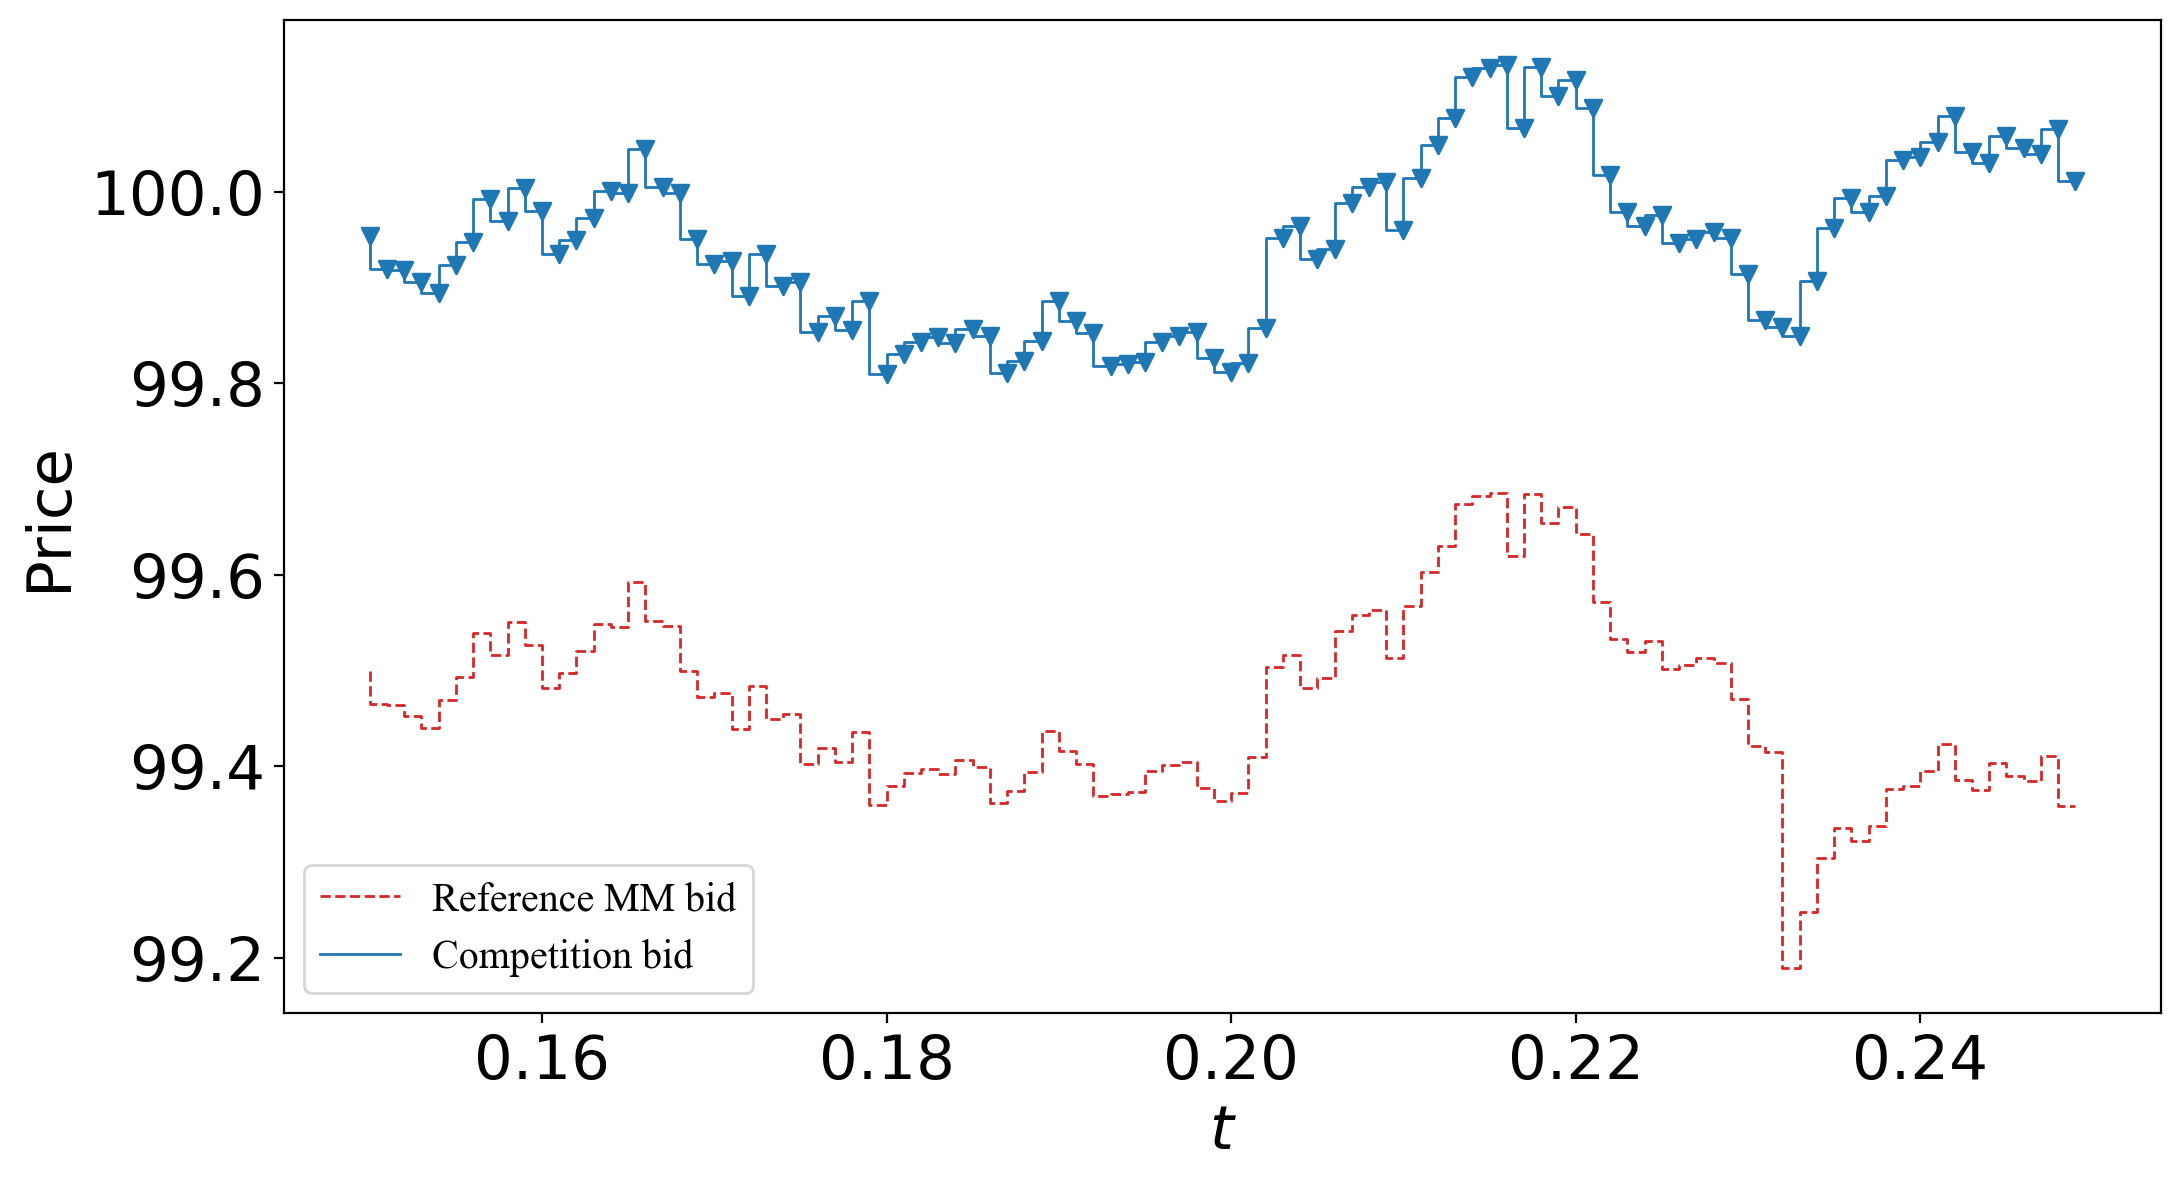

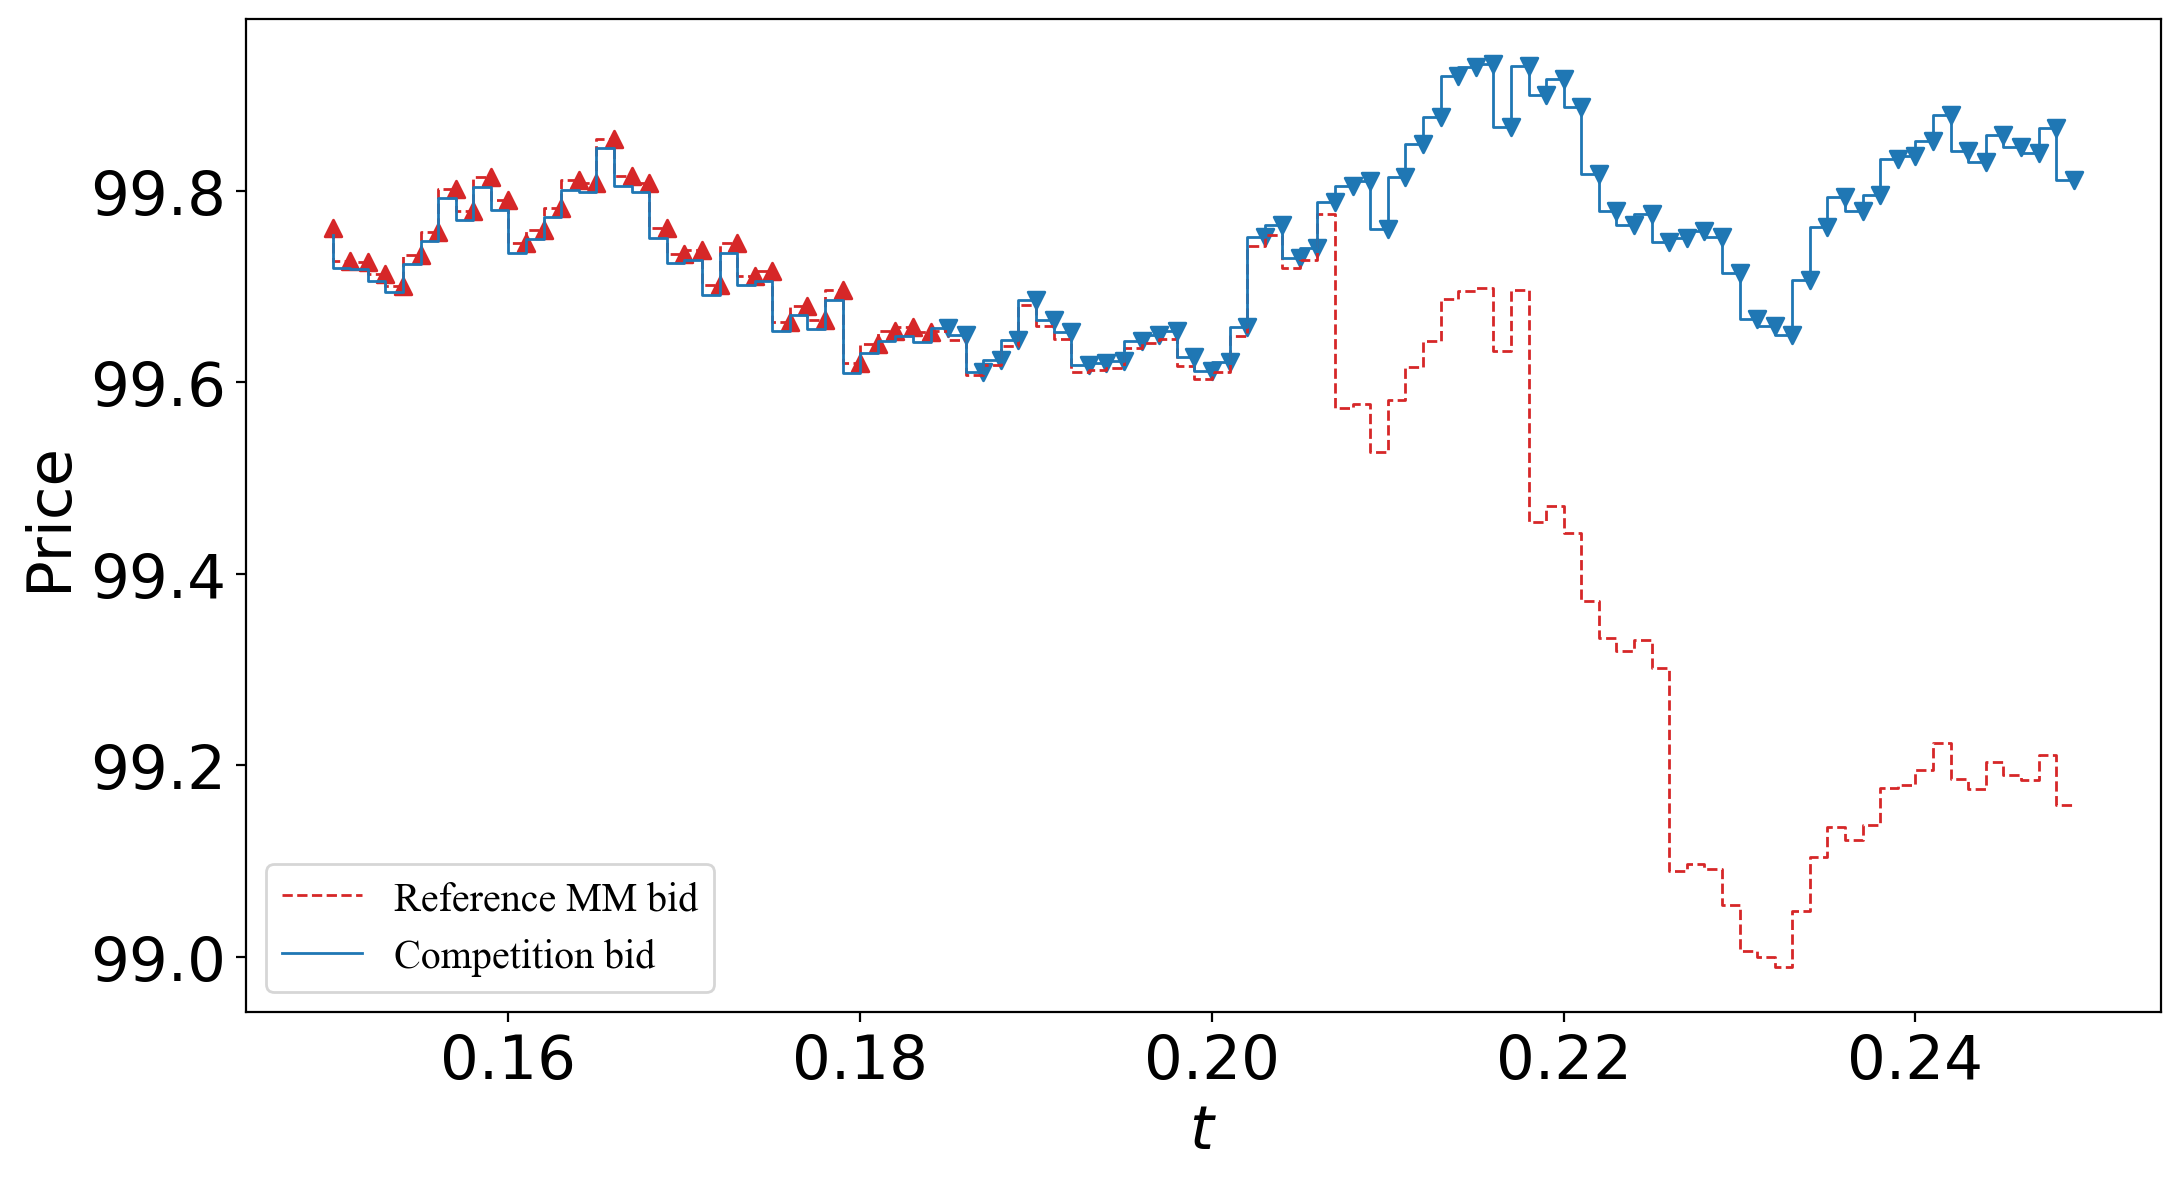

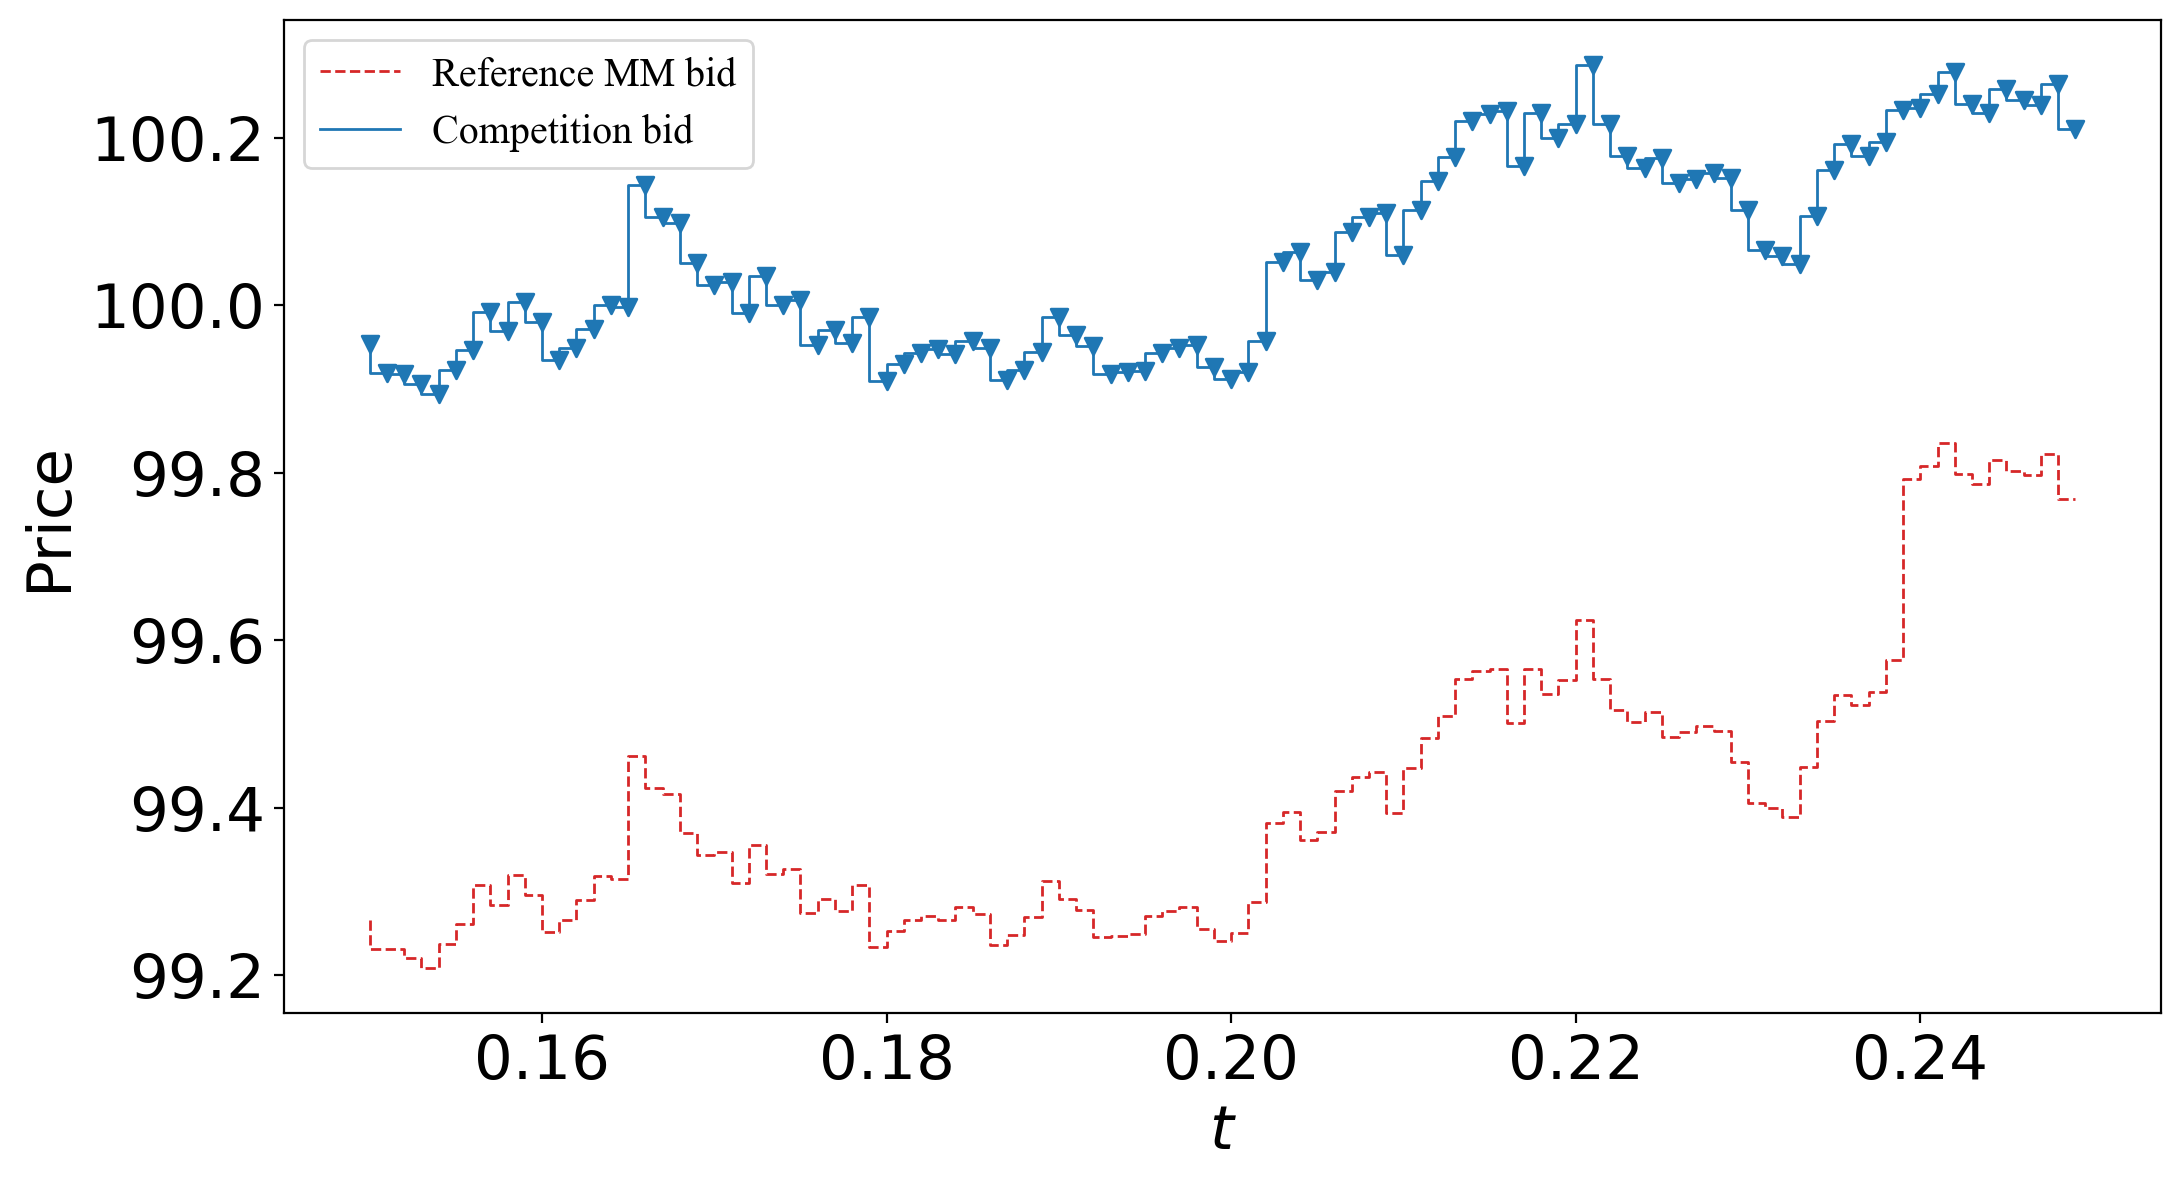

In [22]:
for i in range(10):
    sim = 40+i
    plotfrom=int(Nt*0.15)
    plotto = int(Nt*0.25)

    time_aux = time[plotfrom:plotto]
    deltas_a_aux = deltas_a[:,plotfrom:plotto]
    deltas_b_aux = deltas_b[:,plotfrom:plotto]
    tildes_a_aux = tildes_a[:,plotfrom:plotto] 
    tildes_b_aux = tildes_b[:,plotfrom:plotto] 
    S_aux = S[:,plotfrom:plotto]


    webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
    theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
    webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
    theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])



    fig, ax = plt.subplots(1, 1, figsize = (11,6), sharey=False, sharex=True)
    plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red')
    plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue')

    #plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], '--', linewidth=0.8, label="Ref Ask", color="darkgreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="Reference MM bid", color="tab:red")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], linewidth=1, label="Competition bid", color="tab:blue")
    plt.ticklabel_format(axis='y', useOffset=False)
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)
    ax.set_ylabel("Price", fontsize = 22)
    ax.set_xlabel(r'$t$', fontsize = 22)
    #ax.set_title("Realisation of price processes", **tnrfont)
    ax.legend(prop={'family':fontnm})
    plt.tight_layout()
    #plt.savefig('figures/competition_for_TOB.pdf', format="pdf", dpi=dpi)
    plt.show()


In [23]:
deltas_b[sim,plotfrom:plotto]

array([0.779, 0.78 , 0.781, 0.776, 0.775, 0.774, 0.771, 0.764, 0.766,
       0.767, 0.767, 0.769, 0.776, 0.777, 0.777, 0.777, 0.676, 0.678,
       0.675, 0.674, 0.677, 0.676, 0.673, 0.673, 0.671, 0.674, 0.673,
       0.672, 0.672, 0.676, 0.678, 0.685, 0.684, 0.686, 0.684, 0.681,
       0.686, 0.687, 0.686, 0.684, 0.682, 0.681, 0.679, 0.679, 0.68 ,
       0.682, 0.677, 0.67 , 0.668, 0.669, 0.67 , 0.664, 0.663, 0.665,
       0.665, 0.663, 0.661, 0.657, 0.658, 0.659, 0.663, 0.661, 0.659,
       0.665, 0.664, 0.666, 0.665, 0.67 , 0.674, 0.671, 0.671, 0.566,
       0.566, 0.565, 0.563, 0.561, 0.561, 0.564, 0.564, 0.561, 0.559,
       0.557, 0.554, 0.555, 0.547, 0.545, 0.549, 0.543, 0.538, 0.538,
       0.33 , 0.331, 0.326, 0.332, 0.333, 0.34 , 0.342, 0.345, 0.346,
       0.342])

In [24]:
tildes_b[sim,plotfrom:plotto]

array([ 0.091,  0.092,  0.094,  0.09 ,  0.089,  0.088,  0.085,  0.079,
        0.081,  0.082,  0.083,  0.085,  0.093,  0.094,  0.094,  0.094,
       -0.006, -0.004, -0.007, -0.007, -0.004, -0.005, -0.008, -0.007,
       -0.009, -0.005, -0.006, -0.007, -0.006, -0.002,  0.001,  0.007,
        0.007,  0.009,  0.008,  0.005,  0.01 ,  0.012,  0.011,  0.009,
        0.008,  0.007,  0.005,  0.006,  0.007,  0.009,  0.005, -0.002,
       -0.004, -0.002, -0.001, -0.007, -0.008, -0.005, -0.004, -0.006,
       -0.008, -0.011, -0.01 , -0.009, -0.004, -0.006, -0.007, -0.002,
       -0.002,  0.   , -0.001,  0.005,  0.01 ,  0.007,  0.007, -0.097,
       -0.097, -0.098, -0.099, -0.101, -0.101, -0.097, -0.097, -0.099,
       -0.101, -0.103, -0.105, -0.105, -0.112, -0.113, -0.109, -0.114,
       -0.119, -0.119, -0.114, -0.113, -0.117, -0.111, -0.11 , -0.103,
       -0.101, -0.097, -0.096, -0.1  ])

NameError: name 'resolution_value' is not defined

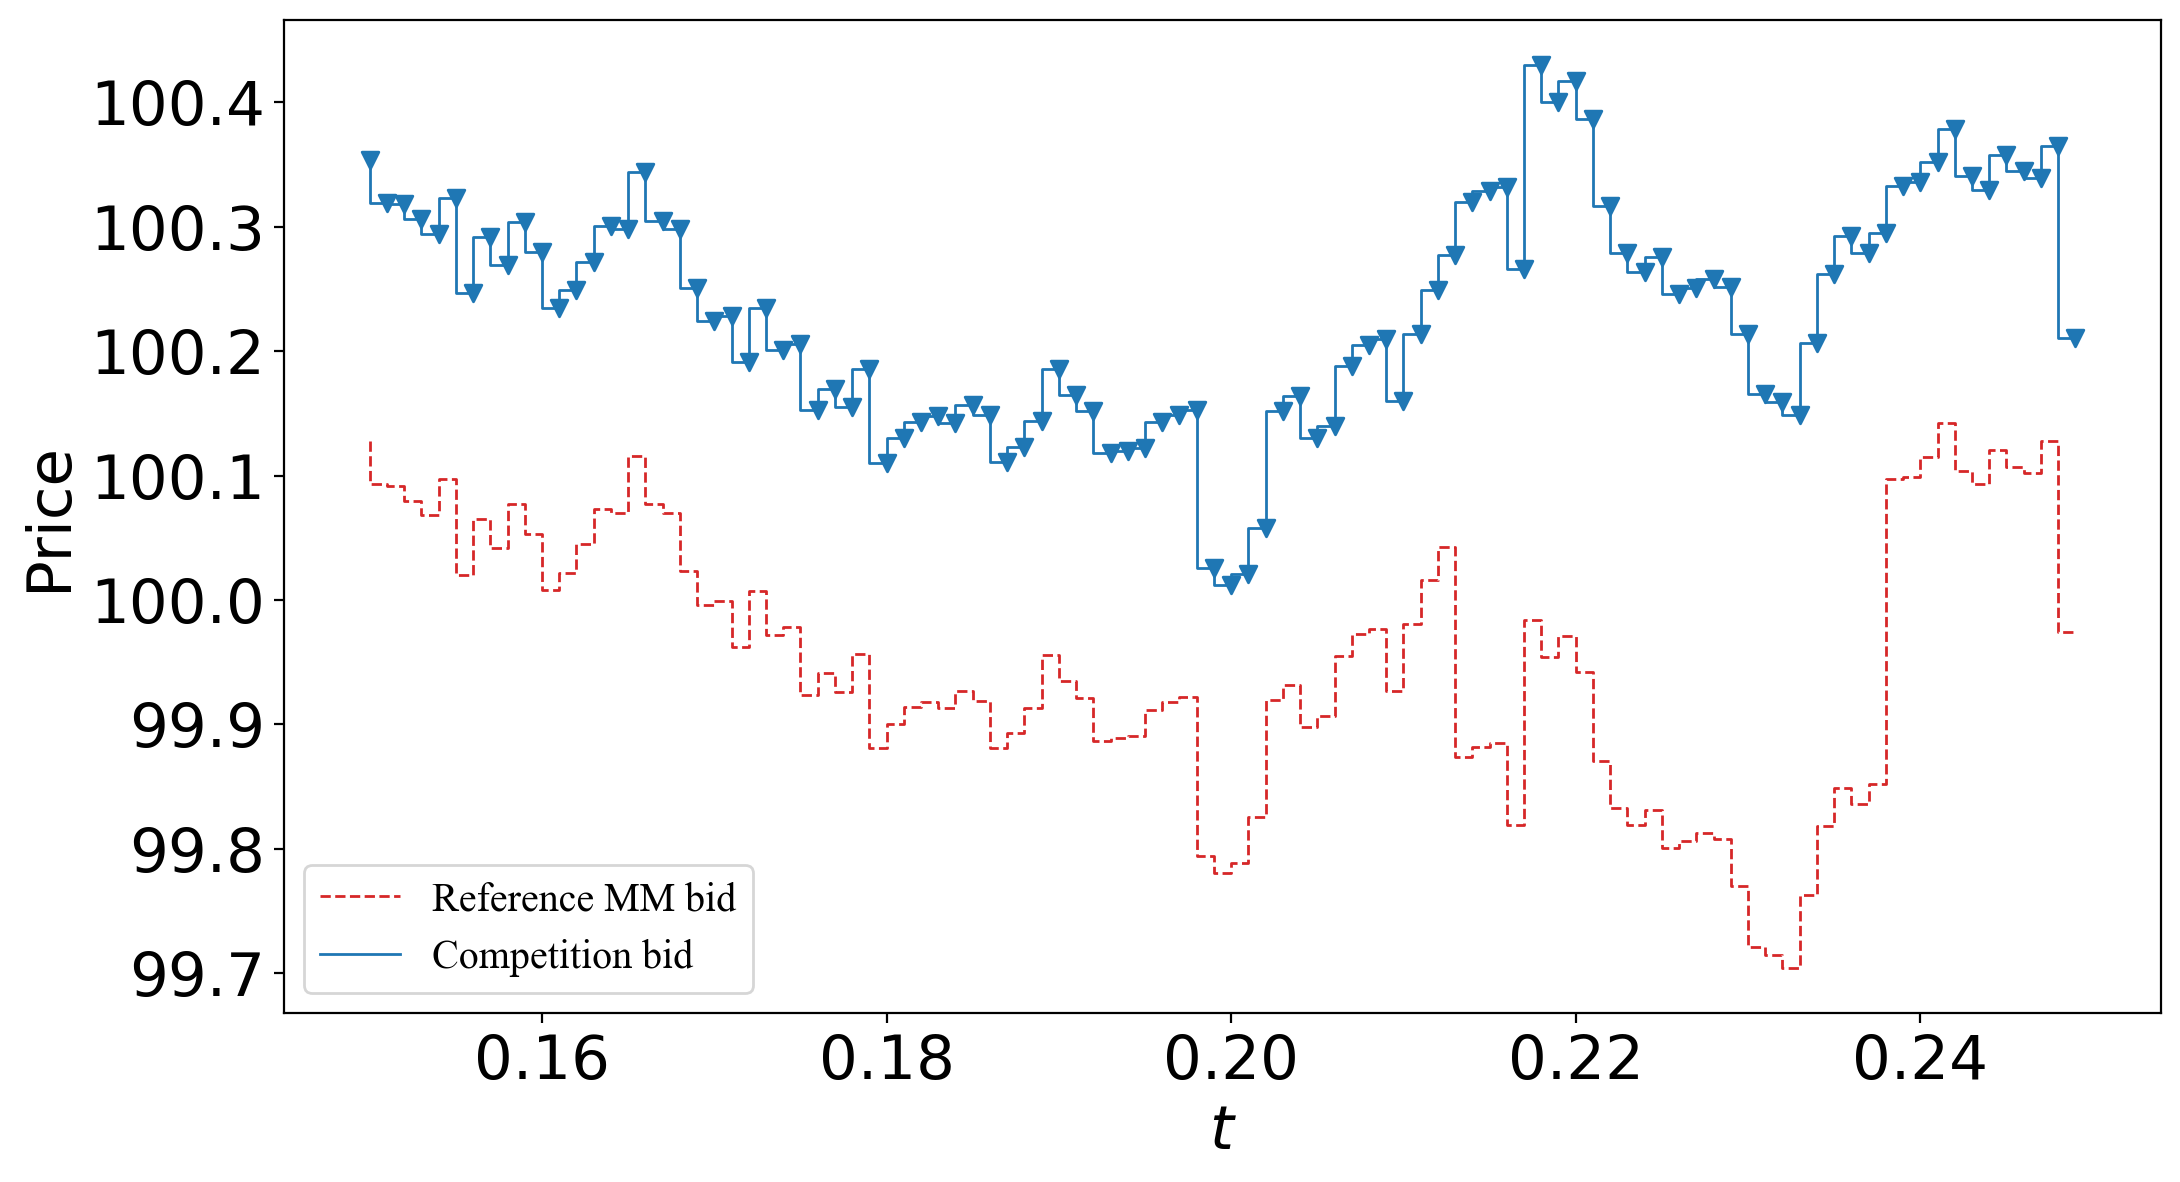

In [25]:
sim = 41
plotfrom=int(Nt*0.15)
plotto = int(Nt*0.25)

time_aux = time[plotfrom:plotto]
deltas_a_aux = deltas_a[:,plotfrom:plotto]
deltas_b_aux = deltas_b[:,plotfrom:plotto]
tildes_a_aux = tildes_a[:,plotfrom:plotto]
tildes_b_aux = tildes_b[:,plotfrom:plotto]
S_aux = S[:,plotfrom:plotto]


webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])



fig, ax = plt.subplots(1, 1, figsize = (11,6), sharey=False, sharex=True)
plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue')
plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red')

#plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
#plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], '--', linewidth=0.8, label="Ref Ask", color="darkgreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="Reference MM bid", color="tab:red")
#plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], linewidth=1, label="Competition bid", color="tab:blue")
plt.ticklabel_format(axis='y', useOffset=False)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.set_ylabel("Price", fontsize = 22)
ax.set_xlabel(r'$t$', fontsize = 22)
#ax.set_title("Realisation of price processes", **tnrfont)
ax.legend(prop={'family':fontnm})
plt.tight_layout()
plt.savefig('figures/competition_for_TOB.pdf', format="pdf", dpi=resolution_value)
plt.show()
